In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/models/epoch_28.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/models/epoch_28.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

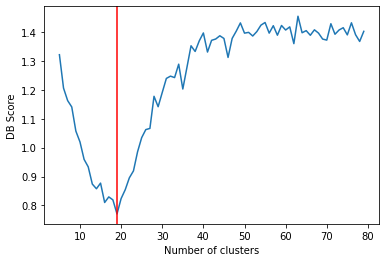

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

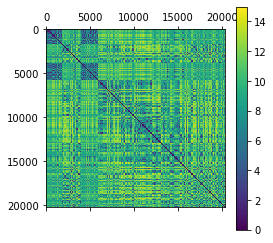

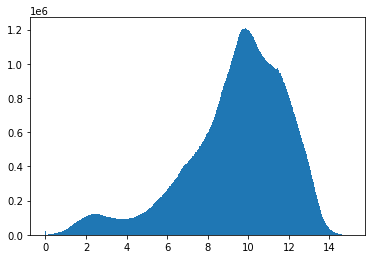

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

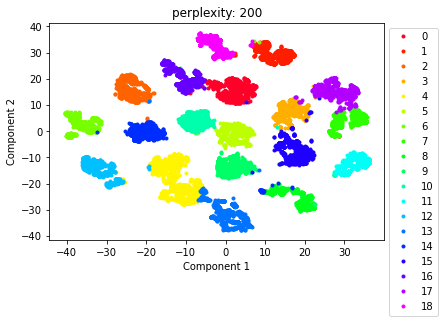

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9955649731434485


In [14]:
losses = []
accs = []
sparsity = []

In [16]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.09877562584744905
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.8035220994475138
layer 6: 0.6335462707182321
layer 7: 0.45584426795580113
layer 8: 0.2781422651933702
layer 9: 0.14872885013812157
layer 10: 0.05601476174033149
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.942 | Reg loss: 0.021 | Tree loss: 2.942 | Accuracy: 0.088500 | 25.683 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.932 | Reg loss: 0.021 | Tree loss: 2.932 | Accuracy: 0.099500 | 17.955 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.925 | Reg loss: 0.020 | Tree loss: 2.925 | Accuracy: 0.103500 | 15.567 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.920 | Reg loss: 0.020 | Tree loss: 2.920 | Accuracy: 0.100500 | 14.789 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.910 | Reg loss: 0.020 | Tree loss: 2.910 | Accuracy: 0.122000 | 13.351 sec/iter
Epoch: 00 | Batch: 005 / 01

Epoch: 04 | Batch: 008 / 011 | Total loss: 2.825 | Reg loss: 0.017 | Tree loss: 2.825 | Accuracy: 0.191000 | 12.45 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 2.818 | Reg loss: 0.017 | Tree loss: 2.818 | Accuracy: 0.191000 | 12.346 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 2.805 | Reg loss: 0.017 | Tree loss: 2.805 | Accuracy: 0.215017 | 12.189 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 2.912 | Reg loss: 0.016 | Tree loss: 2.912 | Accuracy: 0.155500 | 12.904 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.909 | Reg loss: 0.016 | Tree loss: 2.909 | Accuracy: 0.195000 | 12.853 sec/iter
Epoch: 05 | Batch: 002 / 011

Epoch: 09 | Batch: 005 / 011 | Total loss: 2.714 | Reg loss: 0.017 | Tree loss: 2.714 | Accuracy: 0.199500 | 12.223 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 2.687 | Reg loss: 0.017 | Tree loss: 2.687 | Accuracy: 0.194000 | 12.206 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 2.687 | Reg loss: 0.017 | Tree loss: 2.687 | Accuracy: 0.170500 | 12.165 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 2.658 | Reg loss: 0.017 | Tree loss: 2.658 | Accuracy: 0.193500 | 12.129 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 2.641 | Reg loss: 0.018 | Tree loss: 2.641 | Accuracy: 0.186500 | 12.075 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 2.601 | Reg loss: 0.018 | Tree loss: 2.601 | Accuracy: 0.218430 | 11.999 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 14 | Batch: 002 / 011 | Total loss: 2.640 | Reg loss: 0.018 | Tree loss: 2.640 | Accuracy: 0.256500 | 12.001 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 2.580 | Reg loss: 0.018 | Tree loss: 2.580 | Accuracy: 0.261000 | 11.984 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 2.536 | Reg loss: 0.019 | Tree loss: 2.536 | Accuracy: 0.251500 | 11.963 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 2.506 | Reg loss: 0.019 | Tree loss: 2.506 | Accuracy: 0.240000 | 11.946 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 2.478 | Reg loss: 0.019 | Tree loss: 2.478 | Accuracy: 0.234500 | 11.931 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 2.448 | Reg loss: 0.019 | Tree loss: 2.448 | Accuracy: 0.252000 | 11.917 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 2.405 | Reg loss: 0.019 | Tree loss: 2.405 | Accuracy: 0.259500 | 11.89 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 2.385 | Reg loss: 0.019 | Tree loss: 2.385 | Accuracy: 0.255000 | 11.867 sec/iter
E

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 19 | Batch: 000 / 011 | Total loss: 2.512 | Reg loss: 0.020 | Tree loss: 2.512 | Accuracy: 0.270500 | 11.819 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 2.466 | Reg loss: 0.020 | Tree loss: 2.466 | Accuracy: 0.272500 | 11.817 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 2.396 | Reg loss: 0.021 | Tree loss: 2.396 | Accuracy: 0.283000 | 11.812 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 2.364 | Reg loss: 0.021 | Tree loss: 2.364 | Accuracy: 0.274000 | 11.816 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 2.312 | Reg loss: 0.021 | Tree loss: 2.312 | Accuracy: 0.291500 | 11.807 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 2.284 | Reg loss: 0.021 | Tree loss: 2.284 | Accuracy: 0.294000 | 11.805 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 2.257 | Reg loss: 0.021 | Tree loss: 2.257 | Accuracy: 0.293000 | 11.799 sec/iter
Epoch: 19 | Batch: 007 / 011 | Total los

Epoch: 23 | Batch: 010 / 011 | Total loss: 2.058 | Reg loss: 0.023 | Tree loss: 2.058 | Accuracy: 0.327645 | 11.679 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 2.313 | Reg loss: 0.022 | Tree loss: 2.313 | Accuracy: 0.288000 | 11.735 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 2.300 | Reg loss: 0.022 | Tree loss: 2.300 | Accuracy: 0.270500 | 11.734 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 2.234 | Reg loss: 0.022 | Tree loss: 2.234 | Accuracy: 0.284500 | 11.725 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 2.187 | Reg loss: 0.023 | Tree loss: 2.187 | Accuracy: 0.294500 | 11.724 sec/iter
Epoch: 24 | Batch: 004 / 01

Epoch: 28 | Batch: 007 / 011 | Total loss: 1.991 | Reg loss: 0.024 | Tree loss: 1.991 | Accuracy: 0.358000 | 11.509 sec/iter
Epoch: 28 | Batch: 008 / 011 | Total loss: 1.985 | Reg loss: 0.024 | Tree loss: 1.985 | Accuracy: 0.351000 | 11.498 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 1.978 | Reg loss: 0.024 | Tree loss: 1.978 | Accuracy: 0.329500 | 11.484 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 1.966 | Reg loss: 0.024 | Tree loss: 1.966 | Accuracy: 0.375427 | 11.459 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 2.175 | Reg loss: 0.024 | Tree loss: 2.175 | Accuracy: 0.323000 | 11.506 sec/iter
Epoch: 29 | Batch: 001 / 01

Epoch: 33 | Batch: 004 / 011 | Total loss: 1.964 | Reg loss: 0.025 | Tree loss: 1.964 | Accuracy: 0.351000 | 11.37 sec/iter
Epoch: 33 | Batch: 005 / 011 | Total loss: 1.937 | Reg loss: 0.025 | Tree loss: 1.937 | Accuracy: 0.370000 | 11.362 sec/iter
Epoch: 33 | Batch: 006 / 011 | Total loss: 1.930 | Reg loss: 0.025 | Tree loss: 1.930 | Accuracy: 0.355500 | 11.357 sec/iter
Epoch: 33 | Batch: 007 / 011 | Total loss: 1.910 | Reg loss: 0.025 | Tree loss: 1.910 | Accuracy: 0.358500 | 11.352 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 1.913 | Reg loss: 0.025 | Tree loss: 1.913 | Accuracy: 0.357000 | 11.343 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 1.877 | Reg loss: 0.025 | Tree loss: 1.877 | Accuracy: 0.378000 | 11.334 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 1.907 | Reg loss: 0.025 | Tree loss: 1.907 | Accuracy: 0.337884 | 11.32 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
laye

Epoch: 39 | Batch: 001 / 011 | Total loss: 1.955 | Reg loss: 0.026 | Tree loss: 1.955 | Accuracy: 0.360500 | 11.269 sec/iter
Epoch: 39 | Batch: 002 / 011 | Total loss: 1.948 | Reg loss: 0.026 | Tree loss: 1.948 | Accuracy: 0.363500 | 11.262 sec/iter
Epoch: 39 | Batch: 003 / 011 | Total loss: 1.898 | Reg loss: 0.026 | Tree loss: 1.898 | Accuracy: 0.361000 | 11.261 sec/iter
Epoch: 39 | Batch: 004 / 011 | Total loss: 1.886 | Reg loss: 0.026 | Tree loss: 1.886 | Accuracy: 0.393500 | 11.26 sec/iter
Epoch: 39 | Batch: 005 / 011 | Total loss: 1.856 | Reg loss: 0.026 | Tree loss: 1.856 | Accuracy: 0.408000 | 11.257 sec/iter
Epoch: 39 | Batch: 006 / 011 | Total loss: 1.832 | Reg loss: 0.026 | Tree loss: 1.832 | Accuracy: 0.408500 | 11.251 sec/iter
Epoch: 39 | Batch: 007 / 011 | Total loss: 1.803 | Reg loss: 0.026 | Tree loss: 1.803 | Accuracy: 0.398500 | 11.245 sec/iter
Epoch: 39 | Batch: 008 / 011 | Total loss: 1.787 | Reg loss: 0.026 | Tree loss: 1.787 | Accuracy: 0.406500 | 11.244 sec/iter
E

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 44 | Batch: 000 / 011 | Total loss: 1.948 | Reg loss: 0.027 | Tree loss: 1.948 | Accuracy: 0.365000 | 11.211 sec/iter
Epoch: 44 | Batch: 001 / 011 | Total loss: 1.914 | Reg loss: 0.027 | Tree loss: 1.914 | Accuracy: 0.362000 | 11.209 sec/iter
Epoch: 44 | Batch: 002 / 011 | Total loss: 1.875 | Reg loss: 0.027 | Tree loss: 1.875 | Accuracy: 0.369500 | 11.205 sec/iter
Epoch: 44 | Batch: 003 / 011 | Total loss: 1.836 | Reg loss: 0.027 | Tree loss: 1.836 | Accuracy: 0.387500 | 11.201 sec/iter
Epoch: 44 | Batch: 004 / 011 | Total loss: 1.792 | Reg loss: 0.027 | Tree loss: 1.792 | Accuracy: 0.409000 | 11.198 sec/iter
Epoch: 44 | Batch: 005 / 011 | Total loss: 1.772 | Reg loss: 0.027 | Tree loss: 1.772 | Accuracy: 0.409000 | 11.194 sec/iter
Epoch: 44 | Batch: 006 / 011 | Total loss: 1.755 | Reg loss: 0.027 | Tree loss: 1.755 | Accuracy: 0.420000 | 11.193 sec/iter
Epoch: 44 | Batch: 007 / 011 | Total los

Epoch: 48 | Batch: 010 / 011 | Total loss: 1.700 | Reg loss: 0.028 | Tree loss: 1.700 | Accuracy: 0.399317 | 11.151 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 49 | Batch: 000 / 011 | Total loss: 1.896 | Reg loss: 0.028 | Tree loss: 1.896 | Accuracy: 0.348000 | 11.168 sec/iter
Epoch: 49 | Batch: 001 / 011 | Total loss: 1.843 | Reg loss: 0.028 | Tree loss: 1.843 | Accuracy: 0.361000 | 11.166 sec/iter
Epoch: 49 | Batch: 002 / 011 | Total loss: 1.822 | Reg loss: 0.028 | Tree loss: 1.822 | Accuracy: 0.375000 | 11.167 sec/iter
Epoch: 49 | Batch: 003 / 011 | Total loss: 1.786 | Reg loss: 0.028 | Tree loss: 1.786 | Accuracy: 0.387500 | 11.167 sec/iter
Epoch: 49 | Batch: 004 / 01

Epoch: 53 | Batch: 007 / 011 | Total loss: 1.648 | Reg loss: 0.029 | Tree loss: 1.648 | Accuracy: 0.421500 | 11.156 sec/iter
Epoch: 53 | Batch: 008 / 011 | Total loss: 1.634 | Reg loss: 0.029 | Tree loss: 1.634 | Accuracy: 0.425000 | 11.154 sec/iter
Epoch: 53 | Batch: 009 / 011 | Total loss: 1.634 | Reg loss: 0.029 | Tree loss: 1.634 | Accuracy: 0.446000 | 11.152 sec/iter
Epoch: 53 | Batch: 010 / 011 | Total loss: 1.651 | Reg loss: 0.029 | Tree loss: 1.651 | Accuracy: 0.488055 | 11.145 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 54 | Batch: 000 / 011 | Total loss: 1.851 | Reg loss: 0.029 | Tree loss: 1.851 | Accuracy: 0.366500 | 11.158 sec/iter
Epoch: 54 | Batch: 001 / 01

Epoch: 58 | Batch: 004 / 011 | Total loss: 1.698 | Reg loss: 0.029 | Tree loss: 1.698 | Accuracy: 0.408000 | 11.117 sec/iter
Epoch: 58 | Batch: 005 / 011 | Total loss: 1.657 | Reg loss: 0.029 | Tree loss: 1.657 | Accuracy: 0.410000 | 11.112 sec/iter
Epoch: 58 | Batch: 006 / 011 | Total loss: 1.629 | Reg loss: 0.029 | Tree loss: 1.629 | Accuracy: 0.427000 | 11.114 sec/iter
Epoch: 58 | Batch: 007 / 011 | Total loss: 1.620 | Reg loss: 0.029 | Tree loss: 1.620 | Accuracy: 0.409500 | 11.114 sec/iter
Epoch: 58 | Batch: 008 / 011 | Total loss: 1.589 | Reg loss: 0.029 | Tree loss: 1.589 | Accuracy: 0.440000 | 11.115 sec/iter
Epoch: 58 | Batch: 009 / 011 | Total loss: 1.594 | Reg loss: 0.030 | Tree loss: 1.594 | Accuracy: 0.429000 | 11.115 sec/iter
Epoch: 58 | Batch: 010 / 011 | Total loss: 1.561 | Reg loss: 0.030 | Tree loss: 1.561 | Accuracy: 0.412969 | 11.109 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 63 | Batch: 001 / 011 | Total loss: 1.783 | Reg loss: 0.030 | Tree loss: 1.783 | Accuracy: 0.365500 | 11.099 sec/iter
Epoch: 63 | Batch: 002 / 011 | Total loss: 1.735 | Reg loss: 0.030 | Tree loss: 1.735 | Accuracy: 0.377000 | 11.098 sec/iter
Epoch: 63 | Batch: 003 / 011 | Total loss: 1.688 | Reg loss: 0.030 | Tree loss: 1.688 | Accuracy: 0.415000 | 11.098 sec/iter
Epoch: 63 | Batch: 004 / 011 | Total loss: 1.632 | Reg loss: 0.030 | Tree loss: 1.632 | Accuracy: 0.451000 | 11.096 sec/iter
Epoch: 63 | Batch: 005 / 011 | Total loss: 1.626 | Reg loss: 0.030 | Tree loss: 1.626 | Accuracy: 0.452500 | 11.092 sec/iter
Epoch: 63 | Batch: 006 / 011 | Total loss: 1.614 | Reg loss: 0.030 | Tree loss: 1.614 | Accuracy: 0.443000 | 11.09 sec/iter
Epoch: 63 | Batch: 007 / 011 | Total loss: 1.595 | Reg loss: 0.030 | Tree loss: 1.595 | Accuracy: 0.437000 | 11.089 sec/iter
Epoch: 63 | Batch: 008 / 011 | Total loss: 1.580 | Reg loss: 0.030 | Tree loss: 1.580 | Accuracy: 0.443500 | 11.086 sec/iter
E

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 68 | Batch: 000 / 011 | Total loss: 1.796 | Reg loss: 0.030 | Tree loss: 1.796 | Accuracy: 0.374500 | 11.087 sec/iter
Epoch: 68 | Batch: 001 / 011 | Total loss: 1.747 | Reg loss: 0.030 | Tree loss: 1.747 | Accuracy: 0.393500 | 11.083 sec/iter
Epoch: 68 | Batch: 002 / 011 | Total loss: 1.709 | Reg loss: 0.030 | Tree loss: 1.709 | Accuracy: 0.399500 | 11.083 sec/iter
Epoch: 68 | Batch: 003 / 011 | Total loss: 1.655 | Reg loss: 0.030 | Tree loss: 1.655 | Accuracy: 0.405000 | 11.084 sec/iter
Epoch: 68 | Batch: 004 / 011 | Total loss: 1.609 | Reg loss: 0.030 | Tree loss: 1.609 | Accuracy: 0.450000 | 11.084 sec/iter
Epoch: 68 | Batch: 005 / 011 | Total loss: 1.601 | Reg loss: 0.031 | Tree loss: 1.601 | Accuracy: 0.483000 | 11.083 sec/iter
Epoch: 68 | Batch: 006 / 011 | Total loss: 1.571 | Reg loss: 0.031 | Tree loss: 1.571 | Accuracy: 0.473000 | 11.082 sec/iter
Epoch: 68 | Batch: 007 / 011 | Total loss: 1.581 | Reg loss: 0.031 |

Epoch: 72 | Batch: 010 / 011 | Total loss: 1.536 | Reg loss: 0.031 | Tree loss: 1.536 | Accuracy: 0.443686 | 11.039 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 73 | Batch: 000 / 011 | Total loss: 1.754 | Reg loss: 0.031 | Tree loss: 1.754 | Accuracy: 0.376000 | 11.051 sec/iter
Epoch: 73 | Batch: 001 / 011 | Total loss: 1.730 | Reg loss: 0.031 | Tree loss: 1.730 | Accuracy: 0.386000 | 11.05 sec/iter
Epoch: 73 | Batch: 002 / 011 | Total loss: 1.666 | Reg loss: 0.031 | Tree loss: 1.666 | Accuracy: 0.419000 | 11.051 sec/iter
Epoch: 73 | Batch: 003 / 011 | Total loss: 1.652 | Reg loss: 0.031 | Tree loss: 1.652 | Accuracy: 0.406500 | 11.051 sec/iter
Epoch: 73 | Batch: 004 / 011

Epoch: 77 | Batch: 007 / 011 | Total loss: 1.533 | Reg loss: 0.032 | Tree loss: 1.533 | Accuracy: 0.464500 | 11.042 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 1.526 | Reg loss: 0.032 | Tree loss: 1.526 | Accuracy: 0.458500 | 11.043 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 1.530 | Reg loss: 0.032 | Tree loss: 1.530 | Accuracy: 0.458500 | 11.041 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 1.583 | Reg loss: 0.032 | Tree loss: 1.583 | Accuracy: 0.382253 | 11.036 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 78 | Batch: 000 / 011 | Total loss: 1.743 | Reg loss: 0.031 | Tree loss: 1.743 | Accuracy: 0.386500 | 11.046 sec/iter
Epoch: 78 | Batch: 001 / 01

Epoch: 82 | Batch: 004 / 011 | Total loss: 1.572 | Reg loss: 0.032 | Tree loss: 1.572 | Accuracy: 0.431000 | 11.04 sec/iter
Epoch: 82 | Batch: 005 / 011 | Total loss: 1.560 | Reg loss: 0.032 | Tree loss: 1.560 | Accuracy: 0.439500 | 11.04 sec/iter
Epoch: 82 | Batch: 006 / 011 | Total loss: 1.546 | Reg loss: 0.032 | Tree loss: 1.546 | Accuracy: 0.466000 | 11.041 sec/iter
Epoch: 82 | Batch: 007 / 011 | Total loss: 1.508 | Reg loss: 0.032 | Tree loss: 1.508 | Accuracy: 0.461500 | 11.041 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 1.506 | Reg loss: 0.032 | Tree loss: 1.506 | Accuracy: 0.477500 | 11.041 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 1.488 | Reg loss: 0.032 | Tree loss: 1.488 | Accuracy: 0.486000 | 11.043 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 1.530 | Reg loss: 0.032 | Tree loss: 1.530 | Accuracy: 0.488055 | 11.035 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
laye

Epoch: 87 | Batch: 001 / 011 | Total loss: 1.659 | Reg loss: 0.032 | Tree loss: 1.659 | Accuracy: 0.408000 | 11.133 sec/iter
Epoch: 87 | Batch: 002 / 011 | Total loss: 1.639 | Reg loss: 0.032 | Tree loss: 1.639 | Accuracy: 0.402500 | 11.128 sec/iter
Epoch: 87 | Batch: 003 / 011 | Total loss: 1.616 | Reg loss: 0.032 | Tree loss: 1.616 | Accuracy: 0.408000 | 11.126 sec/iter
Epoch: 87 | Batch: 004 / 011 | Total loss: 1.570 | Reg loss: 0.032 | Tree loss: 1.570 | Accuracy: 0.438000 | 11.122 sec/iter
Epoch: 87 | Batch: 005 / 011 | Total loss: 1.525 | Reg loss: 0.032 | Tree loss: 1.525 | Accuracy: 0.458500 | 11.119 sec/iter
Epoch: 87 | Batch: 006 / 011 | Total loss: 1.516 | Reg loss: 0.032 | Tree loss: 1.516 | Accuracy: 0.475500 | 11.117 sec/iter
Epoch: 87 | Batch: 007 / 011 | Total loss: 1.492 | Reg loss: 0.032 | Tree loss: 1.492 | Accuracy: 0.483500 | 11.116 sec/iter
Epoch: 87 | Batch: 008 / 011 | Total loss: 1.486 | Reg loss: 0.032 | Tree loss: 1.486 | Accuracy: 0.486000 | 11.115 sec/iter


layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 92 | Batch: 000 / 011 | Total loss: 1.687 | Reg loss: 0.033 | Tree loss: 1.687 | Accuracy: 0.402500 | 11.145 sec/iter
Epoch: 92 | Batch: 001 / 011 | Total loss: 1.651 | Reg loss: 0.033 | Tree loss: 1.651 | Accuracy: 0.415500 | 11.142 sec/iter
Epoch: 92 | Batch: 002 / 011 | Total loss: 1.634 | Reg loss: 0.033 | Tree loss: 1.634 | Accuracy: 0.410000 | 11.139 sec/iter
Epoch: 92 | Batch: 003 / 011 | Total loss: 1.589 | Reg loss: 0.033 | Tree loss: 1.589 | Accuracy: 0.448000 | 11.137 sec/iter
Epoch: 92 | Batch: 004 / 011 | Total loss: 1.568 | Reg loss: 0.033 | Tree loss: 1.568 | Accuracy: 0.439000 | 11.134 sec/iter
Epoch: 92 | Batch: 005 / 011 | Total loss: 1.512 | Reg loss: 0.033 | Tree loss: 1.512 | Accuracy: 0.463500 | 11.131 sec/iter
Epoch: 92 | Batch: 006 / 011 | Total loss: 1.519 | Reg loss: 0.033 | Tree loss: 1.519 | Accuracy: 0.448000 | 11.127 sec/iter
Epoch: 92 | Batch: 007 / 011 | Total los

Epoch: 96 | Batch: 010 / 011 | Total loss: 1.412 | Reg loss: 0.033 | Tree loss: 1.412 | Accuracy: 0.542662 | 11.047 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 97 | Batch: 000 / 011 | Total loss: 1.693 | Reg loss: 0.033 | Tree loss: 1.693 | Accuracy: 0.385500 | 11.059 sec/iter
Epoch: 97 | Batch: 001 / 011 | Total loss: 1.652 | Reg loss: 0.033 | Tree loss: 1.652 | Accuracy: 0.391500 | 11.058 sec/iter
Epoch: 97 | Batch: 002 / 011 | Total loss: 1.601 | Reg loss: 0.033 | Tree loss: 1.601 | Accuracy: 0.407000 | 11.056 sec/iter
Epoch: 97 | Batch: 003 / 011 | Total loss: 1.571 | Reg loss: 0.033 | Tree loss: 1.571 | Accuracy: 0.429500 | 11.055 sec/iter
Epoch: 97 | Batch: 004 / 01

Epoch: 101 | Batch: 007 / 011 | Total loss: 1.476 | Reg loss: 0.034 | Tree loss: 1.476 | Accuracy: 0.449500 | 10.984 sec/iter
Epoch: 101 | Batch: 008 / 011 | Total loss: 1.466 | Reg loss: 0.034 | Tree loss: 1.466 | Accuracy: 0.464000 | 10.979 sec/iter
Epoch: 101 | Batch: 009 / 011 | Total loss: 1.430 | Reg loss: 0.034 | Tree loss: 1.430 | Accuracy: 0.476000 | 10.978 sec/iter
Epoch: 101 | Batch: 010 / 011 | Total loss: 1.437 | Reg loss: 0.034 | Tree loss: 1.437 | Accuracy: 0.467577 | 10.972 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 102 | Batch: 000 / 011 | Total loss: 1.678 | Reg loss: 0.034 | Tree loss: 1.678 | Accuracy: 0.418500 | 10.985 sec/iter
Epoch: 102 | Batch: 00

Epoch: 106 | Batch: 004 / 011 | Total loss: 1.525 | Reg loss: 0.034 | Tree loss: 1.525 | Accuracy: 0.439000 | 10.919 sec/iter
Epoch: 106 | Batch: 005 / 011 | Total loss: 1.489 | Reg loss: 0.034 | Tree loss: 1.489 | Accuracy: 0.478000 | 10.915 sec/iter
Epoch: 106 | Batch: 006 / 011 | Total loss: 1.457 | Reg loss: 0.034 | Tree loss: 1.457 | Accuracy: 0.463000 | 10.911 sec/iter
Epoch: 106 | Batch: 007 / 011 | Total loss: 1.464 | Reg loss: 0.034 | Tree loss: 1.464 | Accuracy: 0.453500 | 10.909 sec/iter
Epoch: 106 | Batch: 008 / 011 | Total loss: 1.452 | Reg loss: 0.034 | Tree loss: 1.452 | Accuracy: 0.489000 | 10.908 sec/iter
Epoch: 106 | Batch: 009 / 011 | Total loss: 1.435 | Reg loss: 0.034 | Tree loss: 1.435 | Accuracy: 0.481500 | 10.906 sec/iter
Epoch: 106 | Batch: 010 / 011 | Total loss: 1.458 | Reg loss: 0.034 | Tree loss: 1.458 | Accuracy: 0.430034 | 10.9 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.97237569060773

Epoch: 111 | Batch: 001 / 011 | Total loss: 1.632 | Reg loss: 0.034 | Tree loss: 1.632 | Accuracy: 0.398000 | 10.803 sec/iter
Epoch: 111 | Batch: 002 / 011 | Total loss: 1.572 | Reg loss: 0.034 | Tree loss: 1.572 | Accuracy: 0.435500 | 10.801 sec/iter
Epoch: 111 | Batch: 003 / 011 | Total loss: 1.529 | Reg loss: 0.034 | Tree loss: 1.529 | Accuracy: 0.432000 | 10.8 sec/iter
Epoch: 111 | Batch: 004 / 011 | Total loss: 1.519 | Reg loss: 0.034 | Tree loss: 1.519 | Accuracy: 0.434500 | 10.799 sec/iter
Epoch: 111 | Batch: 005 / 011 | Total loss: 1.480 | Reg loss: 0.034 | Tree loss: 1.480 | Accuracy: 0.459500 | 10.799 sec/iter
Epoch: 111 | Batch: 006 / 011 | Total loss: 1.467 | Reg loss: 0.034 | Tree loss: 1.467 | Accuracy: 0.468000 | 10.798 sec/iter
Epoch: 111 | Batch: 007 / 011 | Total loss: 1.435 | Reg loss: 0.034 | Tree loss: 1.435 | Accuracy: 0.483000 | 10.795 sec/iter
Epoch: 111 | Batch: 008 / 011 | Total loss: 1.452 | Reg loss: 0.034 | Tree loss: 1.452 | Accuracy: 0.466000 | 10.793 sec

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 116 | Batch: 000 / 011 | Total loss: 1.653 | Reg loss: 0.035 | Tree loss: 1.653 | Accuracy: 0.430500 | 10.739 sec/iter
Epoch: 116 | Batch: 001 / 011 | Total loss: 1.610 | Reg loss: 0.035 | Tree loss: 1.610 | Accuracy: 0.423000 | 10.738 sec/iter
Epoch: 116 | Batch: 002 / 011 | Total loss: 1.580 | Reg loss: 0.035 | Tree loss: 1.580 | Accuracy: 0.435500 | 10.737 sec/iter
Epoch: 116 | Batch: 003 / 011 | Total loss: 1.555 | Reg loss: 0.035 | Tree loss: 1.555 | Accuracy: 0.428500 | 10.737 sec/iter
Epoch: 116 | Batch: 004 / 011 | Total loss: 1.516 | Reg loss: 0.035 | Tree loss: 1.516 | Accuracy: 0.448500 | 10.735 sec/iter
Epoch: 116 | Batch: 005 / 011 | Total loss: 1.479 | Reg loss: 0.035 | Tree loss: 1.479 | Accuracy: 0.470500 | 10.734 sec/iter
Epoch: 116 | Batch: 006 / 011 | Total loss: 1.448 | Reg loss: 0.035 | Tree loss: 1.448 | Accuracy: 0.462500 | 10.731 sec/iter
Epoch: 116 | Batch: 007 / 011 | Total loss: 1.439 | Reg loss:

Epoch: 120 | Batch: 010 / 011 | Total loss: 1.434 | Reg loss: 0.035 | Tree loss: 1.434 | Accuracy: 0.491468 | 10.671 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 121 | Batch: 000 / 011 | Total loss: 1.653 | Reg loss: 0.035 | Tree loss: 1.653 | Accuracy: 0.401000 | 10.674 sec/iter
Epoch: 121 | Batch: 001 / 011 | Total loss: 1.614 | Reg loss: 0.035 | Tree loss: 1.614 | Accuracy: 0.401500 | 10.673 sec/iter
Epoch: 121 | Batch: 002 / 011 | Total loss: 1.592 | Reg loss: 0.035 | Tree loss: 1.592 | Accuracy: 0.411500 | 10.67 sec/iter
Epoch: 121 | Batch: 003 / 011 | Total loss: 1.527 | Reg loss: 0.035 | Tree loss: 1.527 | Accuracy: 0.449500 | 10.669 sec/iter
Epoch: 121 | Batch: 004

Epoch: 125 | Batch: 007 / 011 | Total loss: 1.422 | Reg loss: 0.035 | Tree loss: 1.422 | Accuracy: 0.470000 | 10.614 sec/iter
Epoch: 125 | Batch: 008 / 011 | Total loss: 1.413 | Reg loss: 0.035 | Tree loss: 1.413 | Accuracy: 0.485000 | 10.612 sec/iter
Epoch: 125 | Batch: 009 / 011 | Total loss: 1.416 | Reg loss: 0.035 | Tree loss: 1.416 | Accuracy: 0.510500 | 10.611 sec/iter
Epoch: 125 | Batch: 010 / 011 | Total loss: 1.421 | Reg loss: 0.035 | Tree loss: 1.421 | Accuracy: 0.505119 | 10.608 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 126 | Batch: 000 / 011 | Total loss: 1.643 | Reg loss: 0.035 | Tree loss: 1.643 | Accuracy: 0.416500 | 10.61 sec/iter
Epoch: 126 | Batch: 001

Epoch: 130 | Batch: 004 / 011 | Total loss: 1.498 | Reg loss: 0.036 | Tree loss: 1.498 | Accuracy: 0.461500 | 10.572 sec/iter
Epoch: 130 | Batch: 005 / 011 | Total loss: 1.458 | Reg loss: 0.036 | Tree loss: 1.458 | Accuracy: 0.455000 | 10.571 sec/iter
Epoch: 130 | Batch: 006 / 011 | Total loss: 1.454 | Reg loss: 0.036 | Tree loss: 1.454 | Accuracy: 0.450500 | 10.569 sec/iter
Epoch: 130 | Batch: 007 / 011 | Total loss: 1.442 | Reg loss: 0.036 | Tree loss: 1.442 | Accuracy: 0.451500 | 10.568 sec/iter
Epoch: 130 | Batch: 008 / 011 | Total loss: 1.418 | Reg loss: 0.036 | Tree loss: 1.418 | Accuracy: 0.484500 | 10.567 sec/iter
Epoch: 130 | Batch: 009 / 011 | Total loss: 1.421 | Reg loss: 0.036 | Tree loss: 1.421 | Accuracy: 0.458500 | 10.565 sec/iter
Epoch: 130 | Batch: 010 / 011 | Total loss: 1.386 | Reg loss: 0.036 | Tree loss: 1.386 | Accuracy: 0.488055 | 10.562 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 135 | Batch: 001 / 011 | Total loss: 1.593 | Reg loss: 0.036 | Tree loss: 1.593 | Accuracy: 0.404000 | 10.528 sec/iter
Epoch: 135 | Batch: 002 / 011 | Total loss: 1.539 | Reg loss: 0.036 | Tree loss: 1.539 | Accuracy: 0.440500 | 10.527 sec/iter
Epoch: 135 | Batch: 003 / 011 | Total loss: 1.511 | Reg loss: 0.036 | Tree loss: 1.511 | Accuracy: 0.447000 | 10.526 sec/iter
Epoch: 135 | Batch: 004 / 011 | Total loss: 1.492 | Reg loss: 0.036 | Tree loss: 1.492 | Accuracy: 0.456500 | 10.526 sec/iter
Epoch: 135 | Batch: 005 / 011 | Total loss: 1.474 | Reg loss: 0.036 | Tree loss: 1.474 | Accuracy: 0.440500 | 10.525 sec/iter
Epoch: 135 | Batch: 006 / 011 | Total loss: 1.443 | Reg loss: 0.036 | Tree loss: 1.443 | Accuracy: 0.471500 | 10.525 sec/iter
Epoch: 135 | Batch: 007 / 011 | Total loss: 1.425 | Reg loss: 0.036 | Tree loss: 1.425 | Accuracy: 0.487000 | 10.523 sec/iter
Epoch: 135 | Batch: 008 / 011 | Total loss: 1.423 | Reg loss: 0.036 | Tree loss: 1.423 | Accuracy: 0.466500 | 10.522 s

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 140 | Batch: 000 / 011 | Total loss: 1.640 | Reg loss: 0.036 | Tree loss: 1.640 | Accuracy: 0.430000 | 10.488 sec/iter
Epoch: 140 | Batch: 001 / 011 | Total loss: 1.592 | Reg loss: 0.036 | Tree loss: 1.592 | Accuracy: 0.415500 | 10.487 sec/iter
Epoch: 140 | Batch: 002 / 011 | Total loss: 1.548 | Reg loss: 0.036 | Tree loss: 1.548 | Accuracy: 0.419500 | 10.485 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 1.509 | Reg loss: 0.036 | Tree loss: 1.509 | Accuracy: 0.423000 | 10.483 sec/iter
Epoch: 140 | Batch: 004 / 011 | Total loss: 1.478 | Reg loss: 0.036 | Tree loss: 1.478 | Accuracy: 0.441500 | 10.482 sec/iter
Epoch: 140 | Batch: 005 / 011 | Total loss: 1.456 | Reg loss: 0.036 | Tree loss: 1.456 | Accuracy: 0.457500 | 10.482 sec/iter
Epoch: 140 | Batch: 006 / 011 | Total loss: 1.427 | Reg loss: 0.036 | Tree loss: 1.427 | Accuracy: 0.472000 | 10.48 sec/iter
Epoch: 140 | Batch: 007 / 011 | Total loss: 1.430 | Reg loss: 

Epoch: 144 | Batch: 010 / 011 | Total loss: 1.378 | Reg loss: 0.037 | Tree loss: 1.378 | Accuracy: 0.474403 | 10.443 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 145 | Batch: 000 / 011 | Total loss: 1.630 | Reg loss: 0.036 | Tree loss: 1.630 | Accuracy: 0.411500 | 10.448 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 1.595 | Reg loss: 0.036 | Tree loss: 1.595 | Accuracy: 0.439000 | 10.446 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 1.545 | Reg loss: 0.036 | Tree loss: 1.545 | Accuracy: 0.437000 | 10.445 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 1.511 | Reg loss: 0.036 | Tree loss: 1.511 | Accuracy: 0.439000 | 10.445 sec/iter
Epoch: 145 | Batch: 00

Epoch: 149 | Batch: 007 / 011 | Total loss: 1.405 | Reg loss: 0.037 | Tree loss: 1.405 | Accuracy: 0.481500 | 10.411 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 1.408 | Reg loss: 0.037 | Tree loss: 1.408 | Accuracy: 0.481500 | 10.412 sec/iter
Epoch: 149 | Batch: 009 / 011 | Total loss: 1.388 | Reg loss: 0.037 | Tree loss: 1.388 | Accuracy: 0.477500 | 10.412 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 1.364 | Reg loss: 0.037 | Tree loss: 1.364 | Accuracy: 0.546075 | 10.41 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 150 | Batch: 000 / 011 | Total loss: 1.634 | Reg loss: 0.037 | Tree loss: 1.634 | Accuracy: 0.427500 | 10.412 sec/iter
Epoch: 150 | Batch: 001

Epoch: 154 | Batch: 004 / 011 | Total loss: 1.476 | Reg loss: 0.037 | Tree loss: 1.476 | Accuracy: 0.445500 | 10.38 sec/iter
Epoch: 154 | Batch: 005 / 011 | Total loss: 1.428 | Reg loss: 0.037 | Tree loss: 1.428 | Accuracy: 0.476000 | 10.379 sec/iter
Epoch: 154 | Batch: 006 / 011 | Total loss: 1.430 | Reg loss: 0.037 | Tree loss: 1.430 | Accuracy: 0.466500 | 10.379 sec/iter
Epoch: 154 | Batch: 007 / 011 | Total loss: 1.409 | Reg loss: 0.037 | Tree loss: 1.409 | Accuracy: 0.481000 | 10.379 sec/iter
Epoch: 154 | Batch: 008 / 011 | Total loss: 1.393 | Reg loss: 0.037 | Tree loss: 1.393 | Accuracy: 0.490000 | 10.379 sec/iter
Epoch: 154 | Batch: 009 / 011 | Total loss: 1.410 | Reg loss: 0.037 | Tree loss: 1.410 | Accuracy: 0.485500 | 10.377 sec/iter
Epoch: 154 | Batch: 010 / 011 | Total loss: 1.412 | Reg loss: 0.037 | Tree loss: 1.412 | Accuracy: 0.460751 | 10.375 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 159 | Batch: 001 / 011 | Total loss: 1.603 | Reg loss: 0.037 | Tree loss: 1.603 | Accuracy: 0.419000 | 10.359 sec/iter
Epoch: 159 | Batch: 002 / 011 | Total loss: 1.538 | Reg loss: 0.037 | Tree loss: 1.538 | Accuracy: 0.425500 | 10.359 sec/iter
Epoch: 159 | Batch: 003 / 011 | Total loss: 1.505 | Reg loss: 0.037 | Tree loss: 1.505 | Accuracy: 0.454500 | 10.359 sec/iter
Epoch: 159 | Batch: 004 / 011 | Total loss: 1.441 | Reg loss: 0.037 | Tree loss: 1.441 | Accuracy: 0.483500 | 10.358 sec/iter
Epoch: 159 | Batch: 005 / 011 | Total loss: 1.434 | Reg loss: 0.037 | Tree loss: 1.434 | Accuracy: 0.473500 | 10.358 sec/iter
Epoch: 159 | Batch: 006 / 011 | Total loss: 1.407 | Reg loss: 0.037 | Tree loss: 1.407 | Accuracy: 0.481000 | 10.357 sec/iter
Epoch: 159 | Batch: 007 / 011 | Total loss: 1.403 | Reg loss: 0.037 | Tree loss: 1.403 | Accuracy: 0.494000 | 10.356 sec/iter
Epoch: 159 | Batch: 008 / 011 | Total loss: 1.409 | Reg loss: 0.037 | Tree loss: 1.409 | Accuracy: 0.497000 | 10.355 s

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 164 | Batch: 000 / 011 | Total loss: 1.636 | Reg loss: 0.037 | Tree loss: 1.636 | Accuracy: 0.408500 | 10.339 sec/iter
Epoch: 164 | Batch: 001 / 011 | Total loss: 1.588 | Reg loss: 0.037 | Tree loss: 1.588 | Accuracy: 0.427000 | 10.339 sec/iter
Epoch: 164 | Batch: 002 / 011 | Total loss: 1.537 | Reg loss: 0.037 | Tree loss: 1.537 | Accuracy: 0.441000 | 10.338 sec/iter
Epoch: 164 | Batch: 003 / 011 | Total loss: 1.512 | Reg loss: 0.037 | Tree loss: 1.512 | Accuracy: 0.431000 | 10.338 sec/iter
Epoch: 164 | Batch: 004 / 011 | Total loss: 1.476 | Reg loss: 0.037 | Tree loss: 1.476 | Accuracy: 0.452500 | 10.338 sec/iter
Epoch: 164 | Batch: 005 / 011 | Total loss: 1.431 | Reg loss: 0.038 | Tree loss: 1.431 | Accuracy: 0.493500 | 10.336 sec/iter
Epoch: 164 | Batch: 006 / 011 | Total loss: 1.395 | Reg loss: 0.038 | Tree loss: 1.395 | Accuracy: 0.501000 | 10.336 sec/iter
Epoch: 164 | Batch: 007 / 011 | Total loss: 1.404 | Reg loss:

Epoch: 168 | Batch: 010 / 011 | Total loss: 1.409 | Reg loss: 0.038 | Tree loss: 1.409 | Accuracy: 0.484642 | 10.309 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 169 | Batch: 000 / 011 | Total loss: 1.642 | Reg loss: 0.038 | Tree loss: 1.642 | Accuracy: 0.409500 | 10.311 sec/iter
Epoch: 169 | Batch: 001 / 011 | Total loss: 1.578 | Reg loss: 0.038 | Tree loss: 1.578 | Accuracy: 0.415000 | 10.309 sec/iter
Epoch: 169 | Batch: 002 / 011 | Total loss: 1.522 | Reg loss: 0.038 | Tree loss: 1.522 | Accuracy: 0.426000 | 10.308 sec/iter
Epoch: 169 | Batch: 003 / 011 | Total loss: 1.495 | Reg loss: 0.038 | Tree loss: 1.495 | Accuracy: 0.455500 | 10.306 sec/iter
Epoch: 169 | Batch: 00

Epoch: 173 | Batch: 007 / 011 | Total loss: 1.405 | Reg loss: 0.038 | Tree loss: 1.405 | Accuracy: 0.490000 | 10.362 sec/iter
Epoch: 173 | Batch: 008 / 011 | Total loss: 1.401 | Reg loss: 0.038 | Tree loss: 1.401 | Accuracy: 0.498500 | 10.36 sec/iter
Epoch: 173 | Batch: 009 / 011 | Total loss: 1.393 | Reg loss: 0.038 | Tree loss: 1.393 | Accuracy: 0.487500 | 10.359 sec/iter
Epoch: 173 | Batch: 010 / 011 | Total loss: 1.412 | Reg loss: 0.038 | Tree loss: 1.412 | Accuracy: 0.498294 | 10.356 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 174 | Batch: 000 / 011 | Total loss: 1.623 | Reg loss: 0.038 | Tree loss: 1.623 | Accuracy: 0.399000 | 10.38 sec/iter
Epoch: 174 | Batch: 001 

Epoch: 178 | Batch: 004 / 011 | Total loss: 1.463 | Reg loss: 0.038 | Tree loss: 1.463 | Accuracy: 0.451500 | 10.477 sec/iter
Epoch: 178 | Batch: 005 / 011 | Total loss: 1.433 | Reg loss: 0.038 | Tree loss: 1.433 | Accuracy: 0.479000 | 10.477 sec/iter
Epoch: 178 | Batch: 006 / 011 | Total loss: 1.429 | Reg loss: 0.038 | Tree loss: 1.429 | Accuracy: 0.496000 | 10.476 sec/iter
Epoch: 178 | Batch: 007 / 011 | Total loss: 1.393 | Reg loss: 0.038 | Tree loss: 1.393 | Accuracy: 0.461500 | 10.476 sec/iter
Epoch: 178 | Batch: 008 / 011 | Total loss: 1.371 | Reg loss: 0.038 | Tree loss: 1.371 | Accuracy: 0.495500 | 10.475 sec/iter
Epoch: 178 | Batch: 009 / 011 | Total loss: 1.388 | Reg loss: 0.038 | Tree loss: 1.388 | Accuracy: 0.497500 | 10.474 sec/iter
Epoch: 178 | Batch: 010 / 011 | Total loss: 1.395 | Reg loss: 0.038 | Tree loss: 1.395 | Accuracy: 0.501706 | 10.471 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 183 | Batch: 001 / 011 | Total loss: 1.556 | Reg loss: 0.038 | Tree loss: 1.556 | Accuracy: 0.432000 | 10.563 sec/iter
Epoch: 183 | Batch: 002 / 011 | Total loss: 1.550 | Reg loss: 0.038 | Tree loss: 1.550 | Accuracy: 0.432000 | 10.563 sec/iter
Epoch: 183 | Batch: 003 / 011 | Total loss: 1.484 | Reg loss: 0.038 | Tree loss: 1.484 | Accuracy: 0.459000 | 10.566 sec/iter
Epoch: 183 | Batch: 004 / 011 | Total loss: 1.458 | Reg loss: 0.038 | Tree loss: 1.458 | Accuracy: 0.491000 | 10.566 sec/iter
Epoch: 183 | Batch: 005 / 011 | Total loss: 1.422 | Reg loss: 0.038 | Tree loss: 1.422 | Accuracy: 0.485500 | 10.565 sec/iter
Epoch: 183 | Batch: 006 / 011 | Total loss: 1.408 | Reg loss: 0.038 | Tree loss: 1.408 | Accuracy: 0.488500 | 10.565 sec/iter
Epoch: 183 | Batch: 007 / 011 | Total loss: 1.389 | Reg loss: 0.038 | Tree loss: 1.389 | Accuracy: 0.486500 | 10.563 sec/iter
Epoch: 183 | Batch: 008 / 011 | Total loss: 1.380 | Reg loss: 0.038 | Tree loss: 1.380 | Accuracy: 0.516500 | 10.561 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 188 | Batch: 000 / 011 | Total loss: 1.605 | Reg loss: 0.039 | Tree loss: 1.605 | Accuracy: 0.443500 | 10.658 sec/iter
Epoch: 188 | Batch: 001 / 011 | Total loss: 1.571 | Reg loss: 0.039 | Tree loss: 1.571 | Accuracy: 0.411000 | 10.659 sec/iter
Epoch: 188 | Batch: 002 / 011 | Total loss: 1.518 | Reg loss: 0.039 | Tree loss: 1.518 | Accuracy: 0.432000 | 10.661 sec/iter
Epoch: 188 | Batch: 003 / 011 | Total loss: 1.500 | Reg loss: 0.039 | Tree loss: 1.500 | Accuracy: 0.436000 | 10.66 sec/iter
Epoch: 188 | Batch: 004 / 011 | Total loss: 1.433 | Reg loss: 0.039 | Tree loss: 1.433 | Accuracy: 0.480500 | 10.66 sec/iter
Epoch: 188 | Batch: 005 

Epoch: 192 | Batch: 008 / 011 | Total loss: 1.372 | Reg loss: 0.039 | Tree loss: 1.372 | Accuracy: 0.513000 | 10.749 sec/iter
Epoch: 192 | Batch: 009 / 011 | Total loss: 1.394 | Reg loss: 0.039 | Tree loss: 1.394 | Accuracy: 0.462000 | 10.751 sec/iter
Epoch: 192 | Batch: 010 / 011 | Total loss: 1.409 | Reg loss: 0.039 | Tree loss: 1.409 | Accuracy: 0.457338 | 10.748 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 193 | Batch: 000 / 011 | Total loss: 1.586 | Reg loss: 0.039 | Tree loss: 1.586 | Accuracy: 0.434500 | 10.766 sec/iter
Epoch: 193 | Batch: 001 / 011 | Total loss: 1.555 | Reg loss: 0.039 | Tree loss: 1.555 | Accuracy: 0.421000 | 10.764 sec/iter
Epoch: 193 | Batch: 00

Epoch: 197 | Batch: 005 / 011 | Total loss: 1.431 | Reg loss: 0.039 | Tree loss: 1.431 | Accuracy: 0.453000 | 10.824 sec/iter
Epoch: 197 | Batch: 006 / 011 | Total loss: 1.419 | Reg loss: 0.039 | Tree loss: 1.419 | Accuracy: 0.446000 | 10.824 sec/iter
Epoch: 197 | Batch: 007 / 011 | Total loss: 1.365 | Reg loss: 0.039 | Tree loss: 1.365 | Accuracy: 0.496500 | 10.824 sec/iter
Epoch: 197 | Batch: 008 / 011 | Total loss: 1.394 | Reg loss: 0.039 | Tree loss: 1.394 | Accuracy: 0.498500 | 10.824 sec/iter
Epoch: 197 | Batch: 009 / 011 | Total loss: 1.358 | Reg loss: 0.039 | Tree loss: 1.358 | Accuracy: 0.520000 | 10.823 sec/iter
Epoch: 197 | Batch: 010 / 011 | Total loss: 1.404 | Reg loss: 0.039 | Tree loss: 1.404 | Accuracy: 0.474403 | 10.82 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 202 | Batch: 002 / 011 | Total loss: 1.534 | Reg loss: 0.039 | Tree loss: 1.534 | Accuracy: 0.416000 | 10.884 sec/iter
Epoch: 202 | Batch: 003 / 011 | Total loss: 1.478 | Reg loss: 0.039 | Tree loss: 1.478 | Accuracy: 0.453000 | 10.883 sec/iter
Epoch: 202 | Batch: 004 / 011 | Total loss: 1.459 | Reg loss: 0.039 | Tree loss: 1.459 | Accuracy: 0.467500 | 10.883 sec/iter
Epoch: 202 | Batch: 005 / 011 | Total loss: 1.408 | Reg loss: 0.039 | Tree loss: 1.408 | Accuracy: 0.496000 | 10.883 sec/iter
Epoch: 202 | Batch: 006 / 011 | Total loss: 1.405 | Reg loss: 0.039 | Tree loss: 1.405 | Accuracy: 0.477500 | 10.883 sec/iter
Epoch: 202 | Batch: 007 / 011 | Total loss: 1.396 | Reg loss: 0.039 | Tree loss: 1.396 | Accuracy: 0.499500 | 10.884 sec/iter
Epoch: 202 | Batch: 008 / 011 | Total loss: 1.378 | Reg loss: 0.039 | Tree loss: 1.378 | Accuracy: 0.499000 | 10.885 sec/iter
Epoch: 202 | Batch: 009 / 011 | Total loss: 1.381 | Reg loss: 0.039 | Tree loss: 1.381 | Accuracy: 0.512500 | 10.885 s

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 207 | Batch: 000 / 011 | Total loss: 1.577 | Reg loss: 0.039 | Tree loss: 1.577 | Accuracy: 0.436500 | 10.953 sec/iter
Epoch: 207 | Batch: 001 / 011 | Total loss: 1.569 | Reg loss: 0.039 | Tree loss: 1.569 | Accuracy: 0.415500 | 10.954 sec/iter
Epoch: 207 | Batch: 002 / 011 | Total loss: 1.507 | Reg loss: 0.039 | Tree loss: 1.507 | Accuracy: 0.436500 | 10.955 sec/iter
Epoch: 207 | Batch: 003 / 011 | Total loss: 1.483 | Reg loss: 0.039 | Tree loss: 1.483 | Accuracy: 0.440000 | 10.956 sec/iter
Epoch: 207 | Batch: 004 / 011 | Total loss: 1.440 | Reg loss: 0.039 | Tree loss: 1.440 | Accuracy: 0.479500 | 10.958 sec/iter
Epoch: 207 | Batch: 005 / 011 | Total loss: 1.431 | Reg loss: 0.039 | Tree loss: 1.431 | Accuracy: 0.469000 | 10.957 sec/iter
Epoch: 207 | Batch: 006 / 011 | Total loss: 1.385 | Reg loss: 0.039 | Tree 

Epoch: 211 | Batch: 009 / 011 | Total loss: 1.348 | Reg loss: 0.040 | Tree loss: 1.348 | Accuracy: 0.542000 | 11.022 sec/iter
Epoch: 211 | Batch: 010 / 011 | Total loss: 1.434 | Reg loss: 0.040 | Tree loss: 1.434 | Accuracy: 0.494881 | 11.019 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 212 | Batch: 000 / 011 | Total loss: 1.603 | Reg loss: 0.039 | Tree loss: 1.603 | Accuracy: 0.404500 | 11.037 sec/iter
Epoch: 212 | Batch: 001 / 011 | Total loss: 1.546 | Reg loss: 0.039 | Tree loss: 1.546 | Accuracy: 0.430500 | 11.036 sec/iter
Epoch: 212 | Batch: 002 / 011 | Total loss: 1.513 | Reg loss: 0.039 | Tree loss: 1.513 | Accuracy: 0.436000 | 11.038 sec/iter
Epoch: 212 | Batch: 00

Epoch: 216 | Batch: 006 / 011 | Total loss: 1.378 | Reg loss: 0.040 | Tree loss: 1.378 | Accuracy: 0.514500 | 11.084 sec/iter
Epoch: 216 | Batch: 007 / 011 | Total loss: 1.392 | Reg loss: 0.040 | Tree loss: 1.392 | Accuracy: 0.497500 | 11.085 sec/iter
Epoch: 216 | Batch: 008 / 011 | Total loss: 1.368 | Reg loss: 0.040 | Tree loss: 1.368 | Accuracy: 0.495500 | 11.085 sec/iter
Epoch: 216 | Batch: 009 / 011 | Total loss: 1.390 | Reg loss: 0.040 | Tree loss: 1.390 | Accuracy: 0.492000 | 11.084 sec/iter
Epoch: 216 | Batch: 010 / 011 | Total loss: 1.398 | Reg loss: 0.040 | Tree loss: 1.398 | Accuracy: 0.460751 | 11.081 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 217 | Batch: 00

Epoch: 221 | Batch: 003 / 011 | Total loss: 1.488 | Reg loss: 0.040 | Tree loss: 1.488 | Accuracy: 0.447500 | 11.152 sec/iter
Epoch: 221 | Batch: 004 / 011 | Total loss: 1.452 | Reg loss: 0.040 | Tree loss: 1.452 | Accuracy: 0.457000 | 11.15 sec/iter
Epoch: 221 | Batch: 005 / 011 | Total loss: 1.417 | Reg loss: 0.040 | Tree loss: 1.417 | Accuracy: 0.492000 | 11.149 sec/iter
Epoch: 221 | Batch: 006 / 011 | Total loss: 1.382 | Reg loss: 0.040 | Tree loss: 1.382 | Accuracy: 0.501500 | 11.147 sec/iter
Epoch: 221 | Batch: 007 / 011 | Total loss: 1.392 | Reg loss: 0.040 | Tree loss: 1.392 | Accuracy: 0.490000 | 11.146 sec/iter
Epoch: 221 | Batch: 008 / 011 | Total loss: 1.387 | Reg loss: 0.040 | Tree loss: 1.387 | Accuracy: 0.513500 | 11.145 sec/iter
Epoch: 221 | Batch: 009 / 011 | Total loss: 1.373 | Reg loss: 0.040 | Tree loss: 1.373 | Accuracy: 0.514000 | 11.146 sec/iter
Epoch: 221 | Batch: 010 / 011 | Total loss: 1.408 | Reg loss: 0.040 | Tree loss: 1.408 | Accuracy: 0.488055 | 11.143 se

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 226 | Batch: 000 / 011 | Total loss: 1.567 | Reg loss: 0.040 | Tree loss: 1.567 | Accuracy: 0.434000 | 11.218 sec/iter
Epoch: 226 | Batch: 001 / 011 | Total loss: 1.538 | Reg loss: 0.040 | Tree loss: 1.538 | Accuracy: 0.427500 | 11.216 sec/iter
Epoch: 226 | Batch: 002 / 011 | Total loss: 1.522 | Reg loss: 0.040 | Tree loss: 1.522 | Accuracy: 0.455000 | 11.216 sec/iter
Epoch: 226 | Batch: 003 / 011 | Total loss: 1.456 | Reg loss: 0.040 | Tree loss: 1.456 | Accuracy: 0.461000 | 11.215 sec/iter
Epoch: 226 | Batch: 004 / 011 | Total loss: 1.434 | Reg loss: 0.040 | Tree loss: 1.434 | Accuracy: 0.481500 | 11.214 sec/iter
Epoch: 226 | Batch: 005 / 011 | Total loss: 1.419 | Reg loss: 0.040 | Tree loss: 1.419 | Accuracy: 0.494000 | 11.214 sec/iter
Epoch: 226 | Batch: 006 / 011 | Total loss: 1.380 | Reg loss: 0.040 | Tree loss: 1.380 | Accuracy: 0.476000 | 11.213 sec/iter
Epoch: 226 | Batch: 007 / 011 | T

Epoch: 230 | Batch: 010 / 011 | Total loss: 1.322 | Reg loss: 0.040 | Tree loss: 1.322 | Accuracy: 0.563140 | 11.25 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 231 | Batch: 000 / 011 | Total loss: 1.569 | Reg loss: 0.040 | Tree loss: 1.569 | Accuracy: 0.409000 | 11.265 sec/iter
Epoch: 231 | Batch: 001 / 011 | Total loss: 1.533 | Reg loss: 0.040 | Tree loss: 1.533 | Accuracy: 0.428000 | 11.264 sec/iter
Epoch: 231 | Batch: 002 / 011 | Total loss: 1.487 | Reg loss: 0.040 | Tree loss: 1.487 | Accuracy: 0.467000 | 11.264 sec/iter
Epoch: 231 | Batch: 003 / 011 | Total loss: 1.467 | Reg loss: 0.040 | Tree loss: 1.467 | Accuracy: 0.450500 | 11.264 sec/iter
Epoch: 231 | Batch: 004

Epoch: 235 | Batch: 007 / 011 | Total loss: 1.369 | Reg loss: 0.040 | Tree loss: 1.369 | Accuracy: 0.493000 | 11.307 sec/iter
Epoch: 235 | Batch: 008 / 011 | Total loss: 1.350 | Reg loss: 0.040 | Tree loss: 1.350 | Accuracy: 0.498000 | 11.305 sec/iter
Epoch: 235 | Batch: 009 / 011 | Total loss: 1.373 | Reg loss: 0.040 | Tree loss: 1.373 | Accuracy: 0.504000 | 11.303 sec/iter
Epoch: 235 | Batch: 010 / 011 | Total loss: 1.378 | Reg loss: 0.040 | Tree loss: 1.378 | Accuracy: 0.488055 | 11.3 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 236 | Batch: 000 / 011 | Total loss: 1.568 | Reg loss: 0.040 | Tree loss: 1.568 | Accuracy: 0.434500 | 11.325 sec/iter
Epoch: 236 | Batch: 001 

Epoch: 240 | Batch: 004 / 011 | Total loss: 1.438 | Reg loss: 0.040 | Tree loss: 1.438 | Accuracy: 0.486500 | 11.372 sec/iter
Epoch: 240 | Batch: 005 / 011 | Total loss: 1.423 | Reg loss: 0.040 | Tree loss: 1.423 | Accuracy: 0.506500 | 11.371 sec/iter
Epoch: 240 | Batch: 006 / 011 | Total loss: 1.382 | Reg loss: 0.040 | Tree loss: 1.382 | Accuracy: 0.516000 | 11.371 sec/iter
Epoch: 240 | Batch: 007 / 011 | Total loss: 1.386 | Reg loss: 0.040 | Tree loss: 1.386 | Accuracy: 0.506500 | 11.371 sec/iter
Epoch: 240 | Batch: 008 / 011 | Total loss: 1.387 | Reg loss: 0.040 | Tree loss: 1.387 | Accuracy: 0.505500 | 11.371 sec/iter
Epoch: 240 | Batch: 009 / 011 | Total loss: 1.370 | Reg loss: 0.040 | Tree loss: 1.370 | Accuracy: 0.517000 | 11.372 sec/iter
Epoch: 240 | Batch: 010 / 011 | Total loss: 1.386 | Reg loss: 0.040 | Tree loss: 1.386 | Accuracy: 0.453925 | 11.37 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 245 | Batch: 001 / 011 | Total loss: 1.560 | Reg loss: 0.040 | Tree loss: 1.560 | Accuracy: 0.430000 | 11.415 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 1.508 | Reg loss: 0.040 | Tree loss: 1.508 | Accuracy: 0.416000 | 11.414 sec/iter
Epoch: 245 | Batch: 003 / 011 | Total loss: 1.450 | Reg loss: 0.040 | Tree loss: 1.450 | Accuracy: 0.454000 | 11.414 sec/iter
Epoch: 245 | Batch: 004 / 011 | Total loss: 1.431 | Reg loss: 0.040 | Tree loss: 1.431 | Accuracy: 0.458000 | 11.413 sec/iter
Epoch: 245 | Batch: 005 / 011 | Total loss: 1.431 | Reg loss: 0.040 | Tree loss: 1.431 | Accuracy: 0.465500 | 11.412 sec/iter
Epoch: 245 | Batch: 006 / 011 | Total loss: 1.388 | Reg loss: 0.040 | Tree loss: 1.388 | Accuracy: 0.484000 | 11.412 sec/iter
Epoch: 245 | Batch: 007 / 011 | Total loss: 1.379 | Reg loss: 0.040 | Tree loss: 1.379 | Accuracy: 0.480000 | 11.411 sec/iter
Epoch: 245 | Batch: 008 / 011 | Total loss: 1.368 | Reg loss: 0.040 | Tree loss: 1.368 | Accuracy: 0.490000 | 11.411 s

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 250 | Batch: 000 / 011 | Total loss: 1.580 | Reg loss: 0.040 | Tree loss: 1.580 | Accuracy: 0.432500 | 11.46 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 1.545 | Reg loss: 0.040 | Tree loss: 1.545 | Accuracy: 0.411500 | 11.46 sec/iter
Epoch: 250 | Batch: 002 / 011 | Total loss: 1.490 | Reg loss: 0.040 | Tree loss: 1.490 | Accuracy: 0.441000 | 11.461 sec/iter
Epoch: 250 | Batch: 003 / 011 | Total loss: 1.474 | Reg loss: 0.040 | Tree loss: 1.474 | Accuracy: 0.457500 | 11.462 sec/iter
Epoch: 250 | Batch: 004 / 011 | Total loss: 1.443 | Reg loss: 0.040 | Tree loss: 1.443 | Accuracy: 0.470500 | 11.462 sec/iter
Epoch: 250 | Batch: 005 / 011 | Total loss: 1.419 | Reg loss: 0.040 | Tree loss: 1.419 | Accuracy: 0.482500 | 11.462 sec/iter
Epoch: 250 | Batch: 006 / 011 | Total loss: 1.390 | Reg loss: 0.041 | Tree loss: 1.390 | Accuracy: 0.4920

Epoch: 254 | Batch: 009 / 011 | Total loss: 1.361 | Reg loss: 0.041 | Tree loss: 1.361 | Accuracy: 0.509500 | 11.507 sec/iter
Epoch: 254 | Batch: 010 / 011 | Total loss: 1.375 | Reg loss: 0.041 | Tree loss: 1.375 | Accuracy: 0.511945 | 11.504 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 255 | Batch: 000 / 011 | Total loss: 1.584 | Reg loss: 0.041 | Tree loss: 1.584 | Accuracy: 0.423500 | 11.511 sec/iter
Epoch: 255 | Batch: 001 / 011 | Total loss: 1.527 | Reg loss: 0.041 | Tree loss: 1.527 | Accuracy: 0.433000 | 11.51 sec/iter
Epoch: 255 | Batch: 002 / 011 | Total loss: 1.493 | Reg loss: 0.041 | Tree loss: 1.493 | Accuracy: 0.437500 | 11.508 sec/iter
Epoch: 255 | Batch: 003

Epoch: 259 | Batch: 006 / 011 | Total loss: 1.402 | Reg loss: 0.041 | Tree loss: 1.402 | Accuracy: 0.482500 | 11.501 sec/iter
Epoch: 259 | Batch: 007 / 011 | Total loss: 1.376 | Reg loss: 0.041 | Tree loss: 1.376 | Accuracy: 0.517000 | 11.501 sec/iter
Epoch: 259 | Batch: 008 / 011 | Total loss: 1.356 | Reg loss: 0.041 | Tree loss: 1.356 | Accuracy: 0.524000 | 11.501 sec/iter
Epoch: 259 | Batch: 009 / 011 | Total loss: 1.377 | Reg loss: 0.041 | Tree loss: 1.377 | Accuracy: 0.504000 | 11.5 sec/iter
Epoch: 259 | Batch: 010 / 011 | Total loss: 1.396 | Reg loss: 0.041 | Tree loss: 1.396 | Accuracy: 0.515358 | 11.497 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 260 | Batch: 000 

Epoch: 264 | Batch: 003 / 011 | Total loss: 1.471 | Reg loss: 0.041 | Tree loss: 1.471 | Accuracy: 0.468000 | 11.505 sec/iter
Epoch: 264 | Batch: 004 / 011 | Total loss: 1.432 | Reg loss: 0.041 | Tree loss: 1.432 | Accuracy: 0.479500 | 11.505 sec/iter
Epoch: 264 | Batch: 005 / 011 | Total loss: 1.384 | Reg loss: 0.041 | Tree loss: 1.384 | Accuracy: 0.512000 | 11.505 sec/iter
Epoch: 264 | Batch: 006 / 011 | Total loss: 1.390 | Reg loss: 0.041 | Tree loss: 1.390 | Accuracy: 0.490500 | 11.504 sec/iter
Epoch: 264 | Batch: 007 / 011 | Total loss: 1.396 | Reg loss: 0.041 | Tree loss: 1.396 | Accuracy: 0.480500 | 11.503 sec/iter
Epoch: 264 | Batch: 008 / 011 | Total loss: 1.369 | Reg loss: 0.041 | Tree loss: 1.369 | Accuracy: 0.487000 | 11.503 sec/iter
Epoch: 264 | Batch: 009 / 011 | Total loss: 1.374 | Reg loss: 0.041 | Tree loss: 1.374 | Accuracy: 0.496500 | 11.502 sec/iter
Epoch: 264 | Batch: 010 / 011 | Total loss: 1.356 | Reg loss: 0.041 | Tree loss: 1.356 | Accuracy: 0.494881 | 11.499 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 269 | Batch: 000 / 011 | Total loss: 1.557 | Reg loss: 0.041 | Tree loss: 1.557 | Accuracy: 0.431000 | 11.524 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 1.537 | Reg loss: 0.041 | Tree loss: 1.537 | Accuracy: 0.410500 | 11.524 sec/iter
Epoch: 269 | Batch: 002 / 011 | Total loss: 1.505 | Reg loss: 0.041 | Tree loss: 1.505 | Accuracy: 0.425000 | 11.525 sec/iter
Epoch: 269 | Batch: 003 / 011 | Total loss: 1.475 | Reg loss: 0.041 | Tree loss: 1.475 | Accuracy: 0.452500 | 11.525 sec/iter
Epoch: 269 | Batch: 004 / 011 | Total loss: 1.445 | Reg loss: 0.041 | Tree loss: 1.445 | Accuracy: 0.471000 | 11.525 sec/iter
Epoch: 269 | Batch: 005 / 011 | Total loss: 1.425 | Reg loss: 0.041 | Tree loss: 1.425 | Accuracy: 0.470000 | 11.525 sec/iter
Epoch: 269 | Batch: 006 / 011 | Total loss: 1.403 | Reg loss: 0.041 | Tree loss: 1.403 | Accuracy: 0.480500 | 11.524 sec/iter
Epoch: 269 | Batch: 007 / 011 | T

Epoch: 273 | Batch: 010 / 011 | Total loss: 1.418 | Reg loss: 0.041 | Tree loss: 1.418 | Accuracy: 0.481229 | 11.552 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 274 | Batch: 000 / 011 | Total loss: 1.582 | Reg loss: 0.041 | Tree loss: 1.582 | Accuracy: 0.409000 | 11.563 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 1.526 | Reg loss: 0.041 | Tree loss: 1.526 | Accuracy: 0.425000 | 11.563 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 1.507 | Reg loss: 0.041 | Tree loss: 1.507 | Accuracy: 0.432000 | 11.564 sec/iter
Epoch: 274 | Batch: 003 / 011 | Total loss: 1.457 | Reg loss: 0.041 | Tree loss: 1.457 | Accuracy: 0.458500 | 11.563 sec/iter
Epoch: 274 | Batch: 00

Epoch: 278 | Batch: 007 / 011 | Total loss: 1.363 | Reg loss: 0.041 | Tree loss: 1.363 | Accuracy: 0.499500 | 11.573 sec/iter
Epoch: 278 | Batch: 008 / 011 | Total loss: 1.357 | Reg loss: 0.041 | Tree loss: 1.357 | Accuracy: 0.509000 | 11.574 sec/iter
Epoch: 278 | Batch: 009 / 011 | Total loss: 1.367 | Reg loss: 0.041 | Tree loss: 1.367 | Accuracy: 0.494000 | 11.573 sec/iter
Epoch: 278 | Batch: 010 / 011 | Total loss: 1.378 | Reg loss: 0.041 | Tree loss: 1.378 | Accuracy: 0.525597 | 11.571 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 279 | Batch: 000 / 011 | Total loss: 1.573 | Reg loss: 0.041 | Tree loss: 1.573 | Accuracy: 0.430500 | 11.579 sec/iter
Epoch: 279 | Batch: 00

Epoch: 283 | Batch: 004 / 011 | Total loss: 1.451 | Reg loss: 0.041 | Tree loss: 1.451 | Accuracy: 0.480500 | 11.592 sec/iter
Epoch: 283 | Batch: 005 / 011 | Total loss: 1.409 | Reg loss: 0.041 | Tree loss: 1.409 | Accuracy: 0.494000 | 11.593 sec/iter
Epoch: 283 | Batch: 006 / 011 | Total loss: 1.388 | Reg loss: 0.041 | Tree loss: 1.388 | Accuracy: 0.491000 | 11.592 sec/iter
Epoch: 283 | Batch: 007 / 011 | Total loss: 1.378 | Reg loss: 0.041 | Tree loss: 1.378 | Accuracy: 0.501000 | 11.591 sec/iter
Epoch: 283 | Batch: 008 / 011 | Total loss: 1.392 | Reg loss: 0.041 | Tree loss: 1.392 | Accuracy: 0.490500 | 11.59 sec/iter
Epoch: 283 | Batch: 009 / 011 | Total loss: 1.353 | Reg loss: 0.041 | Tree loss: 1.353 | Accuracy: 0.512500 | 11.589 sec/iter
Epoch: 283 | Batch: 010 / 011 | Total loss: 1.410 | Reg loss: 0.041 | Tree loss: 1.410 | Accuracy: 0.457338 | 11.587 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 288 | Batch: 001 / 011 | Total loss: 1.534 | Reg loss: 0.041 | Tree loss: 1.534 | Accuracy: 0.441500 | 11.606 sec/iter
Epoch: 288 | Batch: 002 / 011 | Total loss: 1.508 | Reg loss: 0.041 | Tree loss: 1.508 | Accuracy: 0.423500 | 11.606 sec/iter
Epoch: 288 | Batch: 003 / 011 | Total loss: 1.449 | Reg loss: 0.041 | Tree loss: 1.449 | Accuracy: 0.454000 | 11.605 sec/iter
Epoch: 288 | Batch: 004 / 011 | Total loss: 1.415 | Reg loss: 0.041 | Tree loss: 1.415 | Accuracy: 0.485500 | 11.604 sec/iter
Epoch: 288 | Batch: 005 / 011 | Total loss: 1.415 | Reg loss: 0.041 | Tree loss: 1.415 | Accuracy: 0.477500 | 11.603 sec/iter
Epoch: 288 | Batch: 006 / 011 | Total loss: 1.396 | Reg loss: 0.041 | Tree loss: 1.396 | Accuracy: 0.470500 | 11.602 sec/iter
Epoch: 288 | Batch: 007 / 011 | Total loss: 1.371 | Reg loss: 0.041 | Tree loss: 1.371 | Accuracy: 0.493000 | 11.601 sec/iter
Epoch: 288 | Batch: 008 / 011 | Total loss: 1.380 | Reg loss: 0.041 | Tree loss: 1.380 | Accuracy: 0.490500 | 11.601 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 293 | Batch: 000 / 011 | Total loss: 1.570 | Reg loss: 0.041 | Tree loss: 1.570 | Accuracy: 0.410000 | 11.616 sec/iter
Epoch: 293 | Batch: 001 / 011 | Total loss: 1.548 | Reg loss: 0.041 | Tree loss: 1.548 | Accuracy: 0.416500 | 11.616 sec/iter
Epoch: 293 | Batch: 002 / 011 | Total loss: 1.508 | Reg loss: 0.041 | Tree loss: 1.508 | Accuracy: 0.429500 | 11.616 sec/iter
Epoch: 293 | Batch: 003 / 011 | Total loss: 1.467 | Reg loss: 0.041 | Tree loss: 1.467 | Accuracy: 0.445000 | 11.616 sec/iter
Epoch: 293 | Batch: 004 / 011 | Total loss: 1.418 | Reg loss: 0.041 | Tree loss: 1.418 | Accuracy: 0.476000 | 11.616 sec/iter
Epoch: 293 | Batch: 00

Epoch: 297 | Batch: 008 / 011 | Total loss: 1.359 | Reg loss: 0.041 | Tree loss: 1.359 | Accuracy: 0.487000 | 11.625 sec/iter
Epoch: 297 | Batch: 009 / 011 | Total loss: 1.390 | Reg loss: 0.041 | Tree loss: 1.390 | Accuracy: 0.469000 | 11.624 sec/iter
Epoch: 297 | Batch: 010 / 011 | Total loss: 1.364 | Reg loss: 0.041 | Tree loss: 1.364 | Accuracy: 0.481229 | 11.623 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 298 | Batch: 000 / 011 | Total loss: 1.556 | Reg loss: 0.041 | Tree loss: 1.556 | Accuracy: 0.429500 | 11.627 sec/iter
Epoch: 298 | Batch: 001 / 011 | Total loss: 1.535 | Reg loss: 0.041 | Tree loss: 1.535 | Accuracy: 0.435000 | 11.626 sec/iter
Epoch: 298 | Batch: 00

Epoch: 302 | Batch: 005 / 011 | Total loss: 1.406 | Reg loss: 0.041 | Tree loss: 1.406 | Accuracy: 0.473500 | 11.667 sec/iter
Epoch: 302 | Batch: 006 / 011 | Total loss: 1.372 | Reg loss: 0.041 | Tree loss: 1.372 | Accuracy: 0.490500 | 11.667 sec/iter
Epoch: 302 | Batch: 007 / 011 | Total loss: 1.366 | Reg loss: 0.041 | Tree loss: 1.366 | Accuracy: 0.507000 | 11.667 sec/iter
Epoch: 302 | Batch: 008 / 011 | Total loss: 1.367 | Reg loss: 0.041 | Tree loss: 1.367 | Accuracy: 0.496500 | 11.669 sec/iter
Epoch: 302 | Batch: 009 / 011 | Total loss: 1.379 | Reg loss: 0.041 | Tree loss: 1.379 | Accuracy: 0.487500 | 11.67 sec/iter
Epoch: 302 | Batch: 010 / 011 | Total loss: 1.416 | Reg loss: 0.041 | Tree loss: 1.416 | Accuracy: 0.477816 | 11.668 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 307 | Batch: 002 / 011 | Total loss: 1.498 | Reg loss: 0.041 | Tree loss: 1.498 | Accuracy: 0.424500 | 11.723 sec/iter
Epoch: 307 | Batch: 003 / 011 | Total loss: 1.465 | Reg loss: 0.041 | Tree loss: 1.465 | Accuracy: 0.452500 | 11.723 sec/iter
Epoch: 307 | Batch: 004 / 011 | Total loss: 1.408 | Reg loss: 0.041 | Tree loss: 1.408 | Accuracy: 0.500000 | 11.723 sec/iter
Epoch: 307 | Batch: 005 / 011 | Total loss: 1.407 | Reg loss: 0.041 | Tree loss: 1.407 | Accuracy: 0.512500 | 11.723 sec/iter
Epoch: 307 | Batch: 006 / 011 | Total loss: 1.394 | Reg loss: 0.041 | Tree loss: 1.394 | Accuracy: 0.497500 | 11.725 sec/iter
Epoch: 307 | Batch: 007 / 011 | Total loss: 1.366 | Reg loss: 0.041 | Tree loss: 1.366 | Accuracy: 0.508000 | 11.726 sec/iter
Epoch: 307 | Batch: 008 / 011 | Total loss: 1.374 | Reg loss: 0.041 | Tree loss: 1.374 | Accuracy: 0.508000 | 11.727 sec/iter
Epoch: 307 | Batch: 009 / 011 | Total loss: 1.360 | Reg loss: 0.041 | Tree loss: 1.360 | Accuracy: 0.506500 | 11.727 s

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 312 | Batch: 000 / 011 | Total loss: 1.559 | Reg loss: 0.041 | Tree loss: 1.559 | Accuracy: 0.427500 | 11.777 sec/iter
Epoch: 312 | Batch: 001 / 011 | Total loss: 1.536 | Reg loss: 0.041 | Tree loss: 1.536 | Accuracy: 0.440500 | 11.777 sec/iter
Epoch: 312 | Batch: 002 / 011 | Total loss: 1.505 | Reg loss: 0.041 | Tree loss: 1.505 | Accuracy: 0.422500 | 11.777 sec/iter
Epoch: 312 | Batch: 003 / 011 | Total loss: 1.468 | Reg loss: 0.041 | Tree loss: 1.468 | Accuracy: 0.439500 | 11.777 sec/iter
Epoch: 312 | Batch: 004 / 011 | Total loss: 1.406 | Reg loss: 0.041 | Tree loss: 1.406 | Accuracy: 0.491000 | 11.777 sec/iter
Epoch: 312 | Batch: 005 / 011 | Total loss: 1.418 | Reg loss: 0.041 | Tree loss: 1.418 | Accuracy: 0.496000 | 11.777 sec/iter
Epoch: 312 | Batch: 006 / 011 | Total loss: 1.3

Epoch: 316 | Batch: 009 / 011 | Total loss: 1.361 | Reg loss: 0.041 | Tree loss: 1.361 | Accuracy: 0.490000 | 11.83 sec/iter
Epoch: 316 | Batch: 010 / 011 | Total loss: 1.332 | Reg loss: 0.041 | Tree loss: 1.332 | Accuracy: 0.559727 | 11.828 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 317 | Batch: 000 / 011 | Total loss: 1.576 | Reg loss: 0.041 | Tree loss: 1.576 | Accuracy: 0.429500 | 11.843 sec/iter
Epoch: 317 | Batch: 001 / 011 | Total loss: 1.537 | Reg loss: 0.041 | Tree loss: 1.537 | Accuracy: 0.426000 | 11.842 sec/iter
Epoch: 317 | Batch: 002 / 011 | Total loss: 1.482 | Reg loss: 0.041 | Tree loss: 1.482 | Accuracy: 0.453500 | 11.841 sec/iter
Epoch: 317 | Batch: 003

Epoch: 321 | Batch: 006 / 011 | Total loss: 1.393 | Reg loss: 0.041 | Tree loss: 1.393 | Accuracy: 0.483500 | 11.888 sec/iter
Epoch: 321 | Batch: 007 / 011 | Total loss: 1.388 | Reg loss: 0.041 | Tree loss: 1.388 | Accuracy: 0.473500 | 11.888 sec/iter
Epoch: 321 | Batch: 008 / 011 | Total loss: 1.337 | Reg loss: 0.041 | Tree loss: 1.337 | Accuracy: 0.501500 | 11.888 sec/iter
Epoch: 321 | Batch: 009 / 011 | Total loss: 1.357 | Reg loss: 0.042 | Tree loss: 1.357 | Accuracy: 0.498000 | 11.888 sec/iter
Epoch: 321 | Batch: 010 / 011 | Total loss: 1.363 | Reg loss: 0.042 | Tree loss: 1.363 | Accuracy: 0.450512 | 11.886 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 322 | Batch: 00

Epoch: 326 | Batch: 003 / 011 | Total loss: 1.468 | Reg loss: 0.041 | Tree loss: 1.468 | Accuracy: 0.457000 | 11.935 sec/iter
Epoch: 326 | Batch: 004 / 011 | Total loss: 1.429 | Reg loss: 0.041 | Tree loss: 1.429 | Accuracy: 0.475500 | 11.936 sec/iter
Epoch: 326 | Batch: 005 / 011 | Total loss: 1.387 | Reg loss: 0.041 | Tree loss: 1.387 | Accuracy: 0.507500 | 11.937 sec/iter
Epoch: 326 | Batch: 006 / 011 | Total loss: 1.397 | Reg loss: 0.041 | Tree loss: 1.397 | Accuracy: 0.492500 | 11.938 sec/iter
Epoch: 326 | Batch: 007 / 011 | Total loss: 1.384 | Reg loss: 0.042 | Tree loss: 1.384 | Accuracy: 0.513500 | 11.937 sec/iter
Epoch: 326 | Batch: 008 / 011 | Total loss: 1.355 | Reg loss: 0.042 | Tree loss: 1.355 | Accuracy: 0.521000 | 11.936 sec/iter
Epoch: 326 | Batch: 009 / 011 | Total loss: 1.355 | Reg loss: 0.042 | Tree loss: 1.355 | Accuracy: 0.521000 | 11.935 sec/iter
Epoch: 326 | Batch: 010 / 011 | Total loss: 1.319 | Reg loss: 0.042 | Tree loss: 1.319 | Accuracy: 0.505119 | 11.932 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 331 | Batch: 000 / 011 | Total loss: 1.578 | Reg loss: 0.041 | Tree loss: 1.578 | Accuracy: 0.416000 | 11.994 sec/iter
Epoch: 331 | Batch: 001 / 011 | Total loss: 1.525 | Reg loss: 0.041 | Tree loss: 1.525 | Accuracy: 0.421500 | 11.993 sec/iter
Epoch: 331 | Batch: 002 / 011 | Total loss: 1.499 | Reg loss: 0.041 | Tree loss: 1.499 | Accuracy: 0.441500 | 11.993 sec/iter
Epoch: 331 | Batch: 003 / 011 | Total loss: 1.438 | Reg loss: 0.041 | Tree loss: 1.438 | Accuracy: 0.462500 | 11.993 sec/iter
Epoch: 331 | Batch: 004 / 011 | Total loss: 1.402 | Reg loss: 0.041 | Tree loss: 1.402 | Accuracy: 0.495500 | 11.992 sec/iter
Epoch: 331 | Batch: 005 / 011 | Total loss: 1.413 | Reg loss: 0.042 | Tree loss: 1.413 | Accuracy: 0.483000 | 11.991 sec/iter
Epoch: 331 | Batch: 006 / 011 | Total loss: 1.381 | Reg loss: 0.042 | Tree loss: 1.381 | Accuracy: 0.511000 | 11.991 sec/iter
Epoch: 331 | Batch: 007 / 011 | T

Epoch: 335 | Batch: 010 / 011 | Total loss: 1.352 | Reg loss: 0.042 | Tree loss: 1.352 | Accuracy: 0.488055 | 12.023 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 336 | Batch: 000 / 011 | Total loss: 1.558 | Reg loss: 0.041 | Tree loss: 1.558 | Accuracy: 0.431000 | 12.034 sec/iter
Epoch: 336 | Batch: 001 / 011 | Total loss: 1.524 | Reg loss: 0.041 | Tree loss: 1.524 | Accuracy: 0.435500 | 12.034 sec/iter
Epoch: 336 | Batch: 002 / 011 | Total loss: 1.485 | Reg loss: 0.042 | Tree loss: 1.485 | Accuracy: 0.430000 | 12.034 sec/iter
Epoch: 336 | Batch: 003 / 011 | Total loss: 1.456 | Reg loss: 0.042 | Tree loss: 1.456 | Accuracy: 0.453000 | 12.034 sec/iter
Epoch: 336 | Batch: 00

Epoch: 340 | Batch: 007 / 011 | Total loss: 1.357 | Reg loss: 0.042 | Tree loss: 1.357 | Accuracy: 0.528500 | 12.083 sec/iter
Epoch: 340 | Batch: 008 / 011 | Total loss: 1.364 | Reg loss: 0.042 | Tree loss: 1.364 | Accuracy: 0.513500 | 12.084 sec/iter
Epoch: 340 | Batch: 009 / 011 | Total loss: 1.375 | Reg loss: 0.042 | Tree loss: 1.375 | Accuracy: 0.500000 | 12.085 sec/iter
Epoch: 340 | Batch: 010 / 011 | Total loss: 1.424 | Reg loss: 0.042 | Tree loss: 1.424 | Accuracy: 0.460751 | 12.083 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 341 | Batch: 000 / 011 | Total loss: 1.573 | Reg loss: 0.042 | Tree loss: 1.573 | Accuracy: 0.412500 | 12.095 sec/iter
Epoch: 341 | Batch: 00

Epoch: 345 | Batch: 004 / 011 | Total loss: 1.422 | Reg loss: 0.042 | Tree loss: 1.422 | Accuracy: 0.469000 | 12.127 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 1.416 | Reg loss: 0.042 | Tree loss: 1.416 | Accuracy: 0.461500 | 12.127 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 1.379 | Reg loss: 0.042 | Tree loss: 1.379 | Accuracy: 0.465000 | 12.127 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 1.372 | Reg loss: 0.042 | Tree loss: 1.372 | Accuracy: 0.492000 | 12.127 sec/iter
Epoch: 345 | Batch: 008 / 011 | Total loss: 1.361 | Reg loss: 0.042 | Tree loss: 1.361 | Accuracy: 0.496500 | 12.127 sec/iter
Epoch: 345 | Batch: 009 / 011 | Total loss: 1.371 | Reg loss: 0.042 | Tree loss: 1.371 | Accuracy: 0.481500 | 12.127 sec/iter
Epoch: 345 | Batch: 010 / 011 | Total loss: 1.356 | Reg loss: 0.042 | Tree loss: 1.356 | Accuracy: 0.511945 | 12.125 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 350 | Batch: 001 / 011 | Total loss: 1.547 | Reg loss: 0.042 | Tree loss: 1.547 | Accuracy: 0.425500 | 12.172 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 1.483 | Reg loss: 0.042 | Tree loss: 1.483 | Accuracy: 0.426000 | 12.172 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 1.448 | Reg loss: 0.042 | Tree loss: 1.448 | Accuracy: 0.455000 | 12.171 sec/iter
Epoch: 350 | Batch: 004 / 011 | Total loss: 1.443 | Reg loss: 0.042 | Tree loss: 1.443 | Accuracy: 0.451500 | 12.171 sec/iter
Epoch: 350 | Batch: 005 / 011 | Total loss: 1.401 | Reg loss: 0.042 | Tree loss: 1.401 | Accuracy: 0.478500 | 12.171 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 1.385 | Reg loss: 0.042 | Tree loss: 1.385 | Accuracy: 0.480500 | 12.17 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 1.372 | Reg loss: 0.042 | Tree loss: 1.372 | Accuracy: 0.502500 | 12.169 sec/iter
Epoch: 350 | Batch: 008 / 011 | Total loss: 1.367 | Reg loss: 0.042 | Tree loss: 1.367 | Accuracy: 0.494500 | 12.168 se

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 355 | Batch: 000 / 011 | Total loss: 1.565 | Reg loss: 0.042 | Tree loss: 1.565 | Accuracy: 0.412000 | 12.223 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 1.520 | Reg loss: 0.042 | Tree loss: 1.520 | Accuracy: 0.450000 | 12.223 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 1.505 | Reg loss: 0.042 | Tree loss: 1.505 | Accuracy: 0.429000 | 12.223 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 1.452 | Reg loss: 0.042 | Tree loss: 1.452 | Accuracy: 0.461500 | 12.224 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 1.432 | Reg loss: 0.042 | Tree loss: 1.432 | Accuracy: 0.467500 | 12.224 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 1.396 | Reg loss: 0.042 | Tree loss: 1.396 | Accuracy: 0.511000 | 12.225 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 1.404 | Reg loss: 0.042 | Tree loss: 1.404 | Accuracy: 0.48

Epoch: 359 | Batch: 009 / 011 | Total loss: 1.377 | Reg loss: 0.042 | Tree loss: 1.377 | Accuracy: 0.488000 | 12.251 sec/iter
Epoch: 359 | Batch: 010 / 011 | Total loss: 1.383 | Reg loss: 0.042 | Tree loss: 1.383 | Accuracy: 0.457338 | 12.249 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 360 | Batch: 000 / 011 | Total loss: 1.557 | Reg loss: 0.042 | Tree loss: 1.557 | Accuracy: 0.435000 | 12.256 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 1.537 | Reg loss: 0.042 | Tree loss: 1.537 | Accuracy: 0.414500 | 12.255 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 1.497 | Reg loss: 0.042 | Tree loss: 1.497 | Accuracy: 0.442000 | 12.255 sec/iter
Epoch: 360 | Batch: 00

Epoch: 364 | Batch: 006 / 011 | Total loss: 1.376 | Reg loss: 0.042 | Tree loss: 1.376 | Accuracy: 0.498000 | 12.297 sec/iter
Epoch: 364 | Batch: 007 / 011 | Total loss: 1.380 | Reg loss: 0.042 | Tree loss: 1.380 | Accuracy: 0.488000 | 12.297 sec/iter
Epoch: 364 | Batch: 008 / 011 | Total loss: 1.364 | Reg loss: 0.042 | Tree loss: 1.364 | Accuracy: 0.514500 | 12.297 sec/iter
Epoch: 364 | Batch: 009 / 011 | Total loss: 1.348 | Reg loss: 0.042 | Tree loss: 1.348 | Accuracy: 0.532000 | 12.296 sec/iter
Epoch: 364 | Batch: 010 / 011 | Total loss: 1.406 | Reg loss: 0.042 | Tree loss: 1.406 | Accuracy: 0.464164 | 12.294 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 365 | Batch: 00

Epoch: 369 | Batch: 003 / 011 | Total loss: 1.440 | Reg loss: 0.042 | Tree loss: 1.440 | Accuracy: 0.479000 | 12.332 sec/iter
Epoch: 369 | Batch: 004 / 011 | Total loss: 1.452 | Reg loss: 0.042 | Tree loss: 1.452 | Accuracy: 0.463000 | 12.332 sec/iter
Epoch: 369 | Batch: 005 / 011 | Total loss: 1.394 | Reg loss: 0.042 | Tree loss: 1.394 | Accuracy: 0.478500 | 12.332 sec/iter
Epoch: 369 | Batch: 006 / 011 | Total loss: 1.369 | Reg loss: 0.042 | Tree loss: 1.369 | Accuracy: 0.484500 | 12.332 sec/iter
Epoch: 369 | Batch: 007 / 011 | Total loss: 1.374 | Reg loss: 0.042 | Tree loss: 1.374 | Accuracy: 0.503500 | 12.332 sec/iter
Epoch: 369 | Batch: 008 / 011 | Total loss: 1.364 | Reg loss: 0.042 | Tree loss: 1.364 | Accuracy: 0.498500 | 12.332 sec/iter
Epoch: 369 | Batch: 009 / 011 | Total loss: 1.355 | Reg loss: 0.042 | Tree loss: 1.355 | Accuracy: 0.497000 | 12.331 sec/iter
Epoch: 369 | Batch: 010 / 011 | Total loss: 1.363 | Reg loss: 0.042 | Tree loss: 1.363 | Accuracy: 0.453925 | 12.329 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 374 | Batch: 000 / 011 | Total loss: 1.577 | Reg loss: 0.042 | Tree loss: 1.577 | Accuracy: 0.415500 | 12.388 sec/iter
Epoch: 374 | Batch: 001 / 011 | Total loss: 1.525 | Reg loss: 0.042 | Tree loss: 1.525 | Accuracy: 0.424500 | 12.387 sec/iter
Epoch: 374 | Batch: 002 / 011 | Total loss: 1.499 | Reg loss: 0.042 | Tree loss: 1.499 | Accuracy: 0.427000 | 12.387 sec/iter
Epoch: 374 | Batch: 003 / 011 | Total loss: 1.449 | Reg loss: 0.042 | Tree loss: 1.449 | Accuracy: 0.440000 | 12.387 sec/iter
Epoch: 374 | Batch: 004 / 011 | Total loss: 1.439 | Reg loss: 0.042 | Tree loss: 1.439 | Accuracy: 0.462500 | 12.387 sec/iter
Epoch: 374 | Batch: 005 / 011 | Total loss: 1.384 | Reg loss: 0.042 | Tree loss: 1.384 | Accuracy: 0.491500 | 12.387 sec/iter
Epoch: 374 | Batch: 006 / 011 | Total loss: 1.382 | Reg loss: 0.042 | Tree loss: 1.382 | Accuracy: 0.483000 | 12.387 sec/iter
Epoch: 374 | Batch: 007 / 011 | T

Epoch: 378 | Batch: 010 / 011 | Total loss: 1.383 | Reg loss: 0.042 | Tree loss: 1.383 | Accuracy: 0.498294 | 12.409 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 379 | Batch: 000 / 011 | Total loss: 1.577 | Reg loss: 0.042 | Tree loss: 1.577 | Accuracy: 0.427500 | 12.416 sec/iter
Epoch: 379 | Batch: 001 / 011 | Total loss: 1.525 | Reg loss: 0.042 | Tree loss: 1.525 | Accuracy: 0.430000 | 12.415 sec/iter
Epoch: 379 | Batch: 002 / 011 | Total loss: 1.480 | Reg loss: 0.042 | Tree loss: 1.480 | Accuracy: 0.456000 | 12.416 sec/iter
Epoch: 379 | Batch: 003 / 011 | Total loss: 1.450 | Reg loss: 0.042 | Tree loss: 1.450 | Accuracy: 0.460000 | 12.417 sec/iter
Epoch: 379 | Batch: 00

Epoch: 383 | Batch: 007 / 011 | Total loss: 1.369 | Reg loss: 0.042 | Tree loss: 1.369 | Accuracy: 0.512500 | 12.445 sec/iter
Epoch: 383 | Batch: 008 / 011 | Total loss: 1.376 | Reg loss: 0.042 | Tree loss: 1.376 | Accuracy: 0.504500 | 12.444 sec/iter
Epoch: 383 | Batch: 009 / 011 | Total loss: 1.364 | Reg loss: 0.042 | Tree loss: 1.364 | Accuracy: 0.507000 | 12.443 sec/iter
Epoch: 383 | Batch: 010 / 011 | Total loss: 1.342 | Reg loss: 0.042 | Tree loss: 1.342 | Accuracy: 0.511945 | 12.441 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 384 | Batch: 000 / 011 | Total loss: 1.560 | Reg loss: 0.042 | Tree loss: 1.560 | Accuracy: 0.430000 | 12.457 sec/iter
Epoch: 384 | Batch: 00

Epoch: 388 | Batch: 004 / 011 | Total loss: 1.420 | Reg loss: 0.042 | Tree loss: 1.420 | Accuracy: 0.480500 | 12.496 sec/iter
Epoch: 388 | Batch: 005 / 011 | Total loss: 1.404 | Reg loss: 0.042 | Tree loss: 1.404 | Accuracy: 0.485500 | 12.496 sec/iter
Epoch: 388 | Batch: 006 / 011 | Total loss: 1.371 | Reg loss: 0.042 | Tree loss: 1.371 | Accuracy: 0.485500 | 12.496 sec/iter
Epoch: 388 | Batch: 007 / 011 | Total loss: 1.363 | Reg loss: 0.042 | Tree loss: 1.363 | Accuracy: 0.505500 | 12.496 sec/iter
Epoch: 388 | Batch: 008 / 011 | Total loss: 1.362 | Reg loss: 0.042 | Tree loss: 1.362 | Accuracy: 0.504500 | 12.496 sec/iter
Epoch: 388 | Batch: 009 / 011 | Total loss: 1.359 | Reg loss: 0.042 | Tree loss: 1.359 | Accuracy: 0.489500 | 12.496 sec/iter
Epoch: 388 | Batch: 010 / 011 | Total loss: 1.382 | Reg loss: 0.042 | Tree loss: 1.382 | Accuracy: 0.453925 | 12.494 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 393 | Batch: 001 / 011 | Total loss: 1.533 | Reg loss: 0.042 | Tree loss: 1.533 | Accuracy: 0.424500 | 12.52 sec/iter
Epoch: 393 | Batch: 002 / 011 | Total loss: 1.500 | Reg loss: 0.042 | Tree loss: 1.500 | Accuracy: 0.422000 | 12.521 sec/iter
Epoch: 393 | Batch: 003 / 011 | Total loss: 1.456 | Reg loss: 0.042 | Tree loss: 1.456 | Accuracy: 0.446000 | 12.522 sec/iter
Epoch: 393 | Batch: 004 / 011 | Total loss: 1.435 | Reg loss: 0.042 | Tree loss: 1.435 | Accuracy: 0.474500 | 12.523 sec/iter
Epoch: 393 | Batch: 005 / 011 | Total loss: 1.380 | Reg loss: 0.042 | Tree loss: 1.380 | Accuracy: 0.491500 | 12.523 sec/iter
Epoch: 393 | Batch: 006 / 011 | Total loss: 1.391 | Reg loss: 0.042 | Tree loss: 1.391 | Accuracy: 0.479500 | 12.523 sec/iter
Epoch: 393 | Batch: 007 / 011 | Total loss: 1.371 | Reg loss: 0.042 | Tree loss: 1.371 | Accuracy: 0.518500 | 12.523 sec/iter
Epoch: 393 | Batch: 008 / 011 | Total loss: 1.366 | Reg loss: 0.042 | Tree loss: 1.366 | Accuracy: 0.494000 | 12.523 se

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 398 | Batch: 000 / 011 | Total loss: 1.554 | Reg loss: 0.042 | Tree loss: 1.554 | Accuracy: 0.428500 | 12.548 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 1.541 | Reg loss: 0.042 | Tree loss: 1.541 | Accuracy: 0.408000 | 12.548 sec/iter
Epoch: 398 | Batch: 002 / 011 | Total loss: 1.474 | Reg loss: 0.042 | Tree loss: 1.474 | Accuracy: 0.446000 | 12.548 sec/iter
Epoch: 398 | Batch: 003 / 011 | Total loss: 1.465 | Reg loss: 0.042 | Tree loss: 1.465 | Accuracy: 0.453500 | 12.548 sec/iter
Epoch: 398 | Batch: 004 / 011 | Total loss: 1.419 | Reg loss: 0.042 | Tree loss: 1.419 | Accuracy: 0.473000 | 12.549 sec/iter
Epoch: 398 | Batch: 005 / 011 | Total loss: 1.417 | Reg loss: 0.042 | Tree loss: 1.417 | Accuracy: 0.463500 | 12.549 sec/iter
Epoch: 398 | Batch: 006 / 011 | Total loss: 1.375 | Reg loss: 0.042 | Tree loss: 1.375 | Accuracy: 0.48

Epoch: 402 | Batch: 009 / 011 | Total loss: 1.354 | Reg loss: 0.042 | Tree loss: 1.354 | Accuracy: 0.498500 | 12.574 sec/iter
Epoch: 402 | Batch: 010 / 011 | Total loss: 1.356 | Reg loss: 0.042 | Tree loss: 1.356 | Accuracy: 0.484642 | 12.572 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 403 | Batch: 000 / 011 | Total loss: 1.561 | Reg loss: 0.042 | Tree loss: 1.561 | Accuracy: 0.426500 | 12.593 sec/iter
Epoch: 403 | Batch: 001 / 011 | Total loss: 1.533 | Reg loss: 0.042 | Tree loss: 1.533 | Accuracy: 0.417000 | 12.592 sec/iter
Epoch: 403 | Batch: 002 / 011 | Total loss: 1.499 | Reg loss: 0.042 | Tree loss: 1.499 | Accuracy: 0.423500 | 12.591 sec/iter
Epoch: 403 | Batch: 00

Epoch: 407 | Batch: 006 / 011 | Total loss: 1.389 | Reg loss: 0.042 | Tree loss: 1.389 | Accuracy: 0.485500 | 12.616 sec/iter
Epoch: 407 | Batch: 007 / 011 | Total loss: 1.359 | Reg loss: 0.042 | Tree loss: 1.359 | Accuracy: 0.498000 | 12.617 sec/iter
Epoch: 407 | Batch: 008 / 011 | Total loss: 1.352 | Reg loss: 0.042 | Tree loss: 1.352 | Accuracy: 0.513000 | 12.617 sec/iter
Epoch: 407 | Batch: 009 / 011 | Total loss: 1.355 | Reg loss: 0.042 | Tree loss: 1.355 | Accuracy: 0.509500 | 12.617 sec/iter
Epoch: 407 | Batch: 010 / 011 | Total loss: 1.310 | Reg loss: 0.042 | Tree loss: 1.310 | Accuracy: 0.559727 | 12.615 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 408 | Batch: 00

Epoch: 412 | Batch: 003 / 011 | Total loss: 1.453 | Reg loss: 0.042 | Tree loss: 1.453 | Accuracy: 0.463500 | 12.642 sec/iter
Epoch: 412 | Batch: 004 / 011 | Total loss: 1.429 | Reg loss: 0.042 | Tree loss: 1.429 | Accuracy: 0.477000 | 12.642 sec/iter
Epoch: 412 | Batch: 005 / 011 | Total loss: 1.406 | Reg loss: 0.042 | Tree loss: 1.406 | Accuracy: 0.481000 | 12.642 sec/iter
Epoch: 412 | Batch: 006 / 011 | Total loss: 1.388 | Reg loss: 0.042 | Tree loss: 1.388 | Accuracy: 0.486500 | 12.642 sec/iter
Epoch: 412 | Batch: 007 / 011 | Total loss: 1.368 | Reg loss: 0.042 | Tree loss: 1.368 | Accuracy: 0.500000 | 12.642 sec/iter
Epoch: 412 | Batch: 008 / 011 | Total loss: 1.365 | Reg loss: 0.042 | Tree loss: 1.365 | Accuracy: 0.499000 | 12.642 sec/iter
Epoch: 412 | Batch: 009 / 011 | Total loss: 1.347 | Reg loss: 0.042 | Tree loss: 1.347 | Accuracy: 0.503000 | 12.641 sec/iter
Epoch: 412 | Batch: 010 / 011 | Total loss: 1.347 | Reg loss: 0.042 | Tree loss: 1.347 | Accuracy: 0.467577 | 12.639 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 417 | Batch: 000 / 011 | Total loss: 1.559 | Reg loss: 0.042 | Tree loss: 1.559 | Accuracy: 0.413000 | 12.687 sec/iter
Epoch: 417 | Batch: 001 / 011 | Total loss: 1.500 | Reg loss: 0.042 | Tree loss: 1.500 | Accuracy: 0.445500 | 12.686 sec/iter
Epoch: 417 | Batch: 002 / 011 | Total loss: 1.503 | Reg loss: 0.042 | Tree loss: 1.503 | Accuracy: 0.420000 | 12.685 sec/iter
Epoch: 417 | Batch: 003 / 011 | Total loss: 1.486 | Reg loss: 0.042 | Tree loss: 1.486 | Accuracy: 0.449000 | 12.684 sec/iter
Epoch: 417 | Batch: 004 / 011 | Total loss: 1.419 | Reg loss: 0.042 | Tree loss: 1.419 | Accuracy: 0.493000 | 12.684 sec/iter
Epoch: 417 | Batch: 005 / 011 | Total loss: 1.401 | Reg loss: 0.042 | Tree loss: 1.401 | Accuracy: 0.498000 | 12.684 sec/iter
Epoch: 417 | Batch: 006 / 011 | Total loss: 1.376 | Reg loss: 0.042 | Tree loss: 1.376 | Accuracy: 0.508000 | 12.684 sec/iter
Epoch: 417 | Batch: 007 / 011 | T

Epoch: 421 | Batch: 010 / 011 | Total loss: 1.401 | Reg loss: 0.042 | Tree loss: 1.401 | Accuracy: 0.522184 | 12.703 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 422 | Batch: 000 / 011 | Total loss: 1.555 | Reg loss: 0.042 | Tree loss: 1.555 | Accuracy: 0.423000 | 12.709 sec/iter
Epoch: 422 | Batch: 001 / 011 | Total loss: 1.550 | Reg loss: 0.042 | Tree loss: 1.550 | Accuracy: 0.416000 | 12.709 sec/iter
Epoch: 422 | Batch: 002 / 011 | Total loss: 1.482 | Reg loss: 0.042 | Tree loss: 1.482 | Accuracy: 0.433500 | 12.709 sec/iter
Epoch: 422 | Batch: 003 / 011 | Total loss: 1.486 | Reg loss: 0.042 | Tree loss: 1.486 | Accuracy: 0.445500 | 12.71 sec/iter
Epoch: 422 | Batch: 004

Epoch: 426 | Batch: 007 / 011 | Total loss: 1.355 | Reg loss: 0.042 | Tree loss: 1.355 | Accuracy: 0.521500 | 12.731 sec/iter
Epoch: 426 | Batch: 008 / 011 | Total loss: 1.336 | Reg loss: 0.042 | Tree loss: 1.336 | Accuracy: 0.521000 | 12.729 sec/iter
Epoch: 426 | Batch: 009 / 011 | Total loss: 1.363 | Reg loss: 0.042 | Tree loss: 1.363 | Accuracy: 0.499500 | 12.729 sec/iter
Epoch: 426 | Batch: 010 / 011 | Total loss: 1.370 | Reg loss: 0.042 | Tree loss: 1.370 | Accuracy: 0.481229 | 12.727 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 427 | Batch: 000 / 011 | Total loss: 1.559 | Reg loss: 0.042 | Tree loss: 1.559 | Accuracy: 0.428000 | 12.738 sec/iter
Epoch: 427 | Batch: 00

Epoch: 431 | Batch: 004 / 011 | Total loss: 1.432 | Reg loss: 0.042 | Tree loss: 1.432 | Accuracy: 0.486000 | 12.766 sec/iter
Epoch: 431 | Batch: 005 / 011 | Total loss: 1.394 | Reg loss: 0.042 | Tree loss: 1.394 | Accuracy: 0.512500 | 12.766 sec/iter
Epoch: 431 | Batch: 006 / 011 | Total loss: 1.380 | Reg loss: 0.042 | Tree loss: 1.380 | Accuracy: 0.516000 | 12.766 sec/iter
Epoch: 431 | Batch: 007 / 011 | Total loss: 1.368 | Reg loss: 0.042 | Tree loss: 1.368 | Accuracy: 0.523000 | 12.766 sec/iter
Epoch: 431 | Batch: 008 / 011 | Total loss: 1.383 | Reg loss: 0.042 | Tree loss: 1.383 | Accuracy: 0.500000 | 12.765 sec/iter
Epoch: 431 | Batch: 009 / 011 | Total loss: 1.363 | Reg loss: 0.042 | Tree loss: 1.363 | Accuracy: 0.484000 | 12.765 sec/iter
Epoch: 431 | Batch: 010 / 011 | Total loss: 1.323 | Reg loss: 0.042 | Tree loss: 1.323 | Accuracy: 0.501706 | 12.763 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 436 | Batch: 001 / 011 | Total loss: 1.524 | Reg loss: 0.042 | Tree loss: 1.524 | Accuracy: 0.442500 | 12.8 sec/iter
Epoch: 436 | Batch: 002 / 011 | Total loss: 1.498 | Reg loss: 0.042 | Tree loss: 1.498 | Accuracy: 0.443500 | 12.799 sec/iter
Epoch: 436 | Batch: 003 / 011 | Total loss: 1.466 | Reg loss: 0.042 | Tree loss: 1.466 | Accuracy: 0.460000 | 12.798 sec/iter
Epoch: 436 | Batch: 004 / 011 | Total loss: 1.407 | Reg loss: 0.042 | Tree loss: 1.407 | Accuracy: 0.498000 | 12.797 sec/iter
Epoch: 436 | Batch: 005 / 011 | Total loss: 1.397 | Reg loss: 0.042 | Tree loss: 1.397 | Accuracy: 0.504000 | 12.795 sec/iter
Epoch: 436 | Batch: 006 / 011 | Total loss: 1.374 | Reg loss: 0.042 | Tree loss: 1.374 | Accuracy: 0.481500 | 12.795 sec/iter
Epoch: 436 | Batch: 007 / 011 | Total loss: 1.366 | Reg loss: 0.042 | Tree loss: 1.366 | Accuracy: 0.513500 | 12.795 sec/iter
Epoch: 436 | Batch: 008 / 011 | Total loss: 1.366 | Reg loss: 0.042 | Tree loss: 1.366 | Accuracy: 0.503500 | 12.795 sec

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 441 | Batch: 000 / 011 | Total loss: 1.568 | Reg loss: 0.042 | Tree loss: 1.568 | Accuracy: 0.425500 | 12.827 sec/iter
Epoch: 441 | Batch: 001 / 011 | Total loss: 1.536 | Reg loss: 0.042 | Tree loss: 1.536 | Accuracy: 0.432500 | 12.827 sec/iter
Epoch: 441 | Batch: 002 / 011 | Total loss: 1.499 | Reg loss: 0.042 | Tree loss: 1.499 | Accuracy: 0.447500 | 12.826 sec/iter
Epoch: 441 | Batch: 003 / 011 | Total loss: 1.441 | Reg loss: 0.042 | Tree loss: 1.441 | Accuracy: 0.486500 | 12.826 sec/iter
Epoch: 441 | Batch: 004 / 011 | Total loss: 1.427 | Reg loss: 0.042 | Tree loss: 1.427 | Accuracy: 0.490500 | 12.827 sec/iter
Epoch: 441 | Batch: 00

Epoch: 445 | Batch: 008 / 011 | Total loss: 1.341 | Reg loss: 0.042 | Tree loss: 1.341 | Accuracy: 0.509500 | 12.845 sec/iter
Epoch: 445 | Batch: 009 / 011 | Total loss: 1.364 | Reg loss: 0.042 | Tree loss: 1.364 | Accuracy: 0.510000 | 12.845 sec/iter
Epoch: 445 | Batch: 010 / 011 | Total loss: 1.373 | Reg loss: 0.042 | Tree loss: 1.373 | Accuracy: 0.498294 | 12.843 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 446 | Batch: 000 / 011 | Total loss: 1.570 | Reg loss: 0.042 | Tree loss: 1.570 | Accuracy: 0.427500 | 12.849 sec/iter
Epoch: 446 | Batch: 001 / 011 | Total loss: 1.540 | Reg loss: 0.042 | Tree loss: 1.540 | Accuracy: 0.422500 | 12.85 sec/iter
Epoch: 446 | Batch: 002

Epoch: 450 | Batch: 005 / 011 | Total loss: 1.372 | Reg loss: 0.042 | Tree loss: 1.372 | Accuracy: 0.520500 | 12.876 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 1.380 | Reg loss: 0.042 | Tree loss: 1.380 | Accuracy: 0.509000 | 12.875 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 1.380 | Reg loss: 0.042 | Tree loss: 1.380 | Accuracy: 0.518000 | 12.874 sec/iter
Epoch: 450 | Batch: 008 / 011 | Total loss: 1.366 | Reg loss: 0.042 | Tree loss: 1.366 | Accuracy: 0.501000 | 12.873 sec/iter
Epoch: 450 | Batch: 009 / 011 | Total loss: 1.374 | Reg loss: 0.042 | Tree loss: 1.374 | Accuracy: 0.504500 | 12.873 sec/iter
Epoch: 450 | Batch: 010 / 011 | Total loss: 1.331 | Reg loss: 0.042 | Tree loss: 1.331 | Accuracy: 0.542662 | 12.871 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 455 | Batch: 002 / 011 | Total loss: 1.487 | Reg loss: 0.042 | Tree loss: 1.487 | Accuracy: 0.429000 | 12.904 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 1.456 | Reg loss: 0.042 | Tree loss: 1.456 | Accuracy: 0.465000 | 12.904 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 1.432 | Reg loss: 0.042 | Tree loss: 1.432 | Accuracy: 0.493500 | 12.903 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 1.395 | Reg loss: 0.042 | Tree loss: 1.395 | Accuracy: 0.490500 | 12.903 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 1.370 | Reg loss: 0.042 | Tree loss: 1.370 | Accuracy: 0.506000 | 12.902 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 1.385 | Reg loss: 0.042 | Tree loss: 1.385 | Accuracy: 0.506000 | 12.902 sec/iter
Epoch: 455 | Batch: 008 / 011 | Total loss: 1.345 | Reg loss: 0.042 | Tree loss: 1.345 | Accuracy: 0.530500 | 12.902 sec/iter
Epoch: 455 | Batch: 009 / 011 | Total loss: 1.368 | Reg loss: 0.042 | Tree loss: 1.368 | Accuracy: 0.506500 | 12.902 s

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 460 | Batch: 000 / 011 | Total loss: 1.565 | Reg loss: 0.042 | Tree loss: 1.565 | Accuracy: 0.426000 | 12.933 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 1.505 | Reg loss: 0.042 | Tree loss: 1.505 | Accuracy: 0.425000 | 12.933 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 1.495 | Reg loss: 0.042 | Tree loss: 1.495 | Accuracy: 0.420500 | 12.932 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 1.462 | Reg loss: 0.042 | Tree loss: 1.462 | Accuracy: 0.441000 | 12.931 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 1.425 | Reg loss: 0.042 | Tree loss: 1.425 | Accuracy: 0.471500 | 12.93 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 1.387 | Reg loss: 0.042 | Tree loss: 1.387 | Accuracy: 0.492000 | 12.93 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 1.390 | Reg loss: 0.042 | Tree lo

Epoch: 464 | Batch: 009 / 011 | Total loss: 1.342 | Reg loss: 0.042 | Tree loss: 1.342 | Accuracy: 0.505000 | 12.947 sec/iter
Epoch: 464 | Batch: 010 / 011 | Total loss: 1.414 | Reg loss: 0.042 | Tree loss: 1.414 | Accuracy: 0.488055 | 12.945 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 465 | Batch: 000 / 011 | Total loss: 1.563 | Reg loss: 0.042 | Tree loss: 1.563 | Accuracy: 0.415500 | 12.959 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 1.539 | Reg loss: 0.042 | Tree loss: 1.539 | Accuracy: 0.431000 | 12.96 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 1.497 | Reg loss: 0.042 | Tree loss: 1.497 | Accuracy: 0.455000 | 12.96 sec/iter
Epoch: 465 | Batch: 003 

Epoch: 469 | Batch: 006 / 011 | Total loss: 1.397 | Reg loss: 0.042 | Tree loss: 1.397 | Accuracy: 0.494500 | 12.985 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 1.367 | Reg loss: 0.042 | Tree loss: 1.367 | Accuracy: 0.508000 | 12.985 sec/iter
Epoch: 469 | Batch: 008 / 011 | Total loss: 1.364 | Reg loss: 0.042 | Tree loss: 1.364 | Accuracy: 0.497500 | 12.985 sec/iter
Epoch: 469 | Batch: 009 / 011 | Total loss: 1.355 | Reg loss: 0.042 | Tree loss: 1.355 | Accuracy: 0.506000 | 12.985 sec/iter
Epoch: 469 | Batch: 010 / 011 | Total loss: 1.302 | Reg loss: 0.042 | Tree loss: 1.302 | Accuracy: 0.532423 | 12.983 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 470 | Batch: 00

Epoch: 474 | Batch: 003 / 011 | Total loss: 1.433 | Reg loss: 0.042 | Tree loss: 1.433 | Accuracy: 0.480000 | 13.004 sec/iter
Epoch: 474 | Batch: 004 / 011 | Total loss: 1.437 | Reg loss: 0.042 | Tree loss: 1.437 | Accuracy: 0.475500 | 13.004 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 1.394 | Reg loss: 0.042 | Tree loss: 1.394 | Accuracy: 0.498000 | 13.003 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 1.374 | Reg loss: 0.042 | Tree loss: 1.374 | Accuracy: 0.511000 | 13.003 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total loss: 1.357 | Reg loss: 0.042 | Tree loss: 1.357 | Accuracy: 0.520000 | 13.003 sec/iter
Epoch: 474 | Batch: 008 / 011 | Total loss: 1.387 | Reg loss: 0.042 | Tree loss: 1.387 | Accuracy: 0.487500 | 13.003 sec/iter
Epoch: 474 | Batch: 009 / 011 | Total loss: 1.370 | Reg loss: 0.042 | Tree loss: 1.370 | Accuracy: 0.494500 | 13.002 sec/iter
Epoch: 474 | Batch: 010 / 011 | Total loss: 1.398 | Reg loss: 0.042 | Tree loss: 1.398 | Accuracy: 0.460751 | 13.001 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 479 | Batch: 000 / 011 | Total loss: 1.572 | Reg loss: 0.042 | Tree loss: 1.572 | Accuracy: 0.423000 | 13.027 sec/iter
Epoch: 479 | Batch: 001 / 011 | Total loss: 1.522 | Reg loss: 0.042 | Tree loss: 1.522 | Accuracy: 0.436500 | 13.028 sec/iter
Epoch: 479 | Batch: 002 / 011 | Total loss: 1.505 | Reg loss: 0.042 | Tree loss: 1.505 | Accuracy: 0.428000 | 13.028 sec/iter
Epoch: 479 | Batch: 003 / 011 | Total loss: 1.473 | Reg loss: 0.042 | Tree loss: 1.473 | Accuracy: 0.460500 | 13.029 sec/iter
Epoch: 479 | Batch: 004 / 011 | Total loss: 1.435 | Reg loss: 0.042 | Tree loss: 1.435 | Accuracy: 0.490000 | 13.028 sec/iter
Epoch: 479 | Batch: 005 / 011 | Total loss: 1.390 | Reg loss: 0.042 | Tree loss: 1.390 | Accuracy: 0.485000 | 13.027 sec/iter
Epoch: 479 | Batch: 006 / 011 | Total loss: 1.357 | Reg loss: 0.042 | Tree loss: 1.357 | Accuracy: 0.507000 | 13.027 sec/iter
Epoch: 479 | Batch: 007 / 011 | T

Epoch: 483 | Batch: 010 / 011 | Total loss: 1.359 | Reg loss: 0.042 | Tree loss: 1.359 | Accuracy: 0.470990 | 13.049 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 484 | Batch: 000 / 011 | Total loss: 1.573 | Reg loss: 0.042 | Tree loss: 1.573 | Accuracy: 0.415500 | 13.055 sec/iter
Epoch: 484 | Batch: 001 / 011 | Total loss: 1.524 | Reg loss: 0.042 | Tree loss: 1.524 | Accuracy: 0.453000 | 13.055 sec/iter
Epoch: 484 | Batch: 002 / 011 | Total loss: 1.494 | Reg loss: 0.042 | Tree loss: 1.494 | Accuracy: 0.439500 | 13.055 sec/iter
Epoch: 484 | Batch: 003 / 011 | Total loss: 1.440 | Reg loss: 0.042 | Tree loss: 1.440 | Accuracy: 0.483500 | 13.055 sec/iter
Epoch: 484 | Batch: 00

Epoch: 488 | Batch: 007 / 011 | Total loss: 1.352 | Reg loss: 0.042 | Tree loss: 1.352 | Accuracy: 0.505000 | 13.07 sec/iter
Epoch: 488 | Batch: 008 / 011 | Total loss: 1.361 | Reg loss: 0.042 | Tree loss: 1.361 | Accuracy: 0.505000 | 13.069 sec/iter
Epoch: 488 | Batch: 009 / 011 | Total loss: 1.379 | Reg loss: 0.042 | Tree loss: 1.379 | Accuracy: 0.501500 | 13.069 sec/iter
Epoch: 488 | Batch: 010 / 011 | Total loss: 1.365 | Reg loss: 0.042 | Tree loss: 1.365 | Accuracy: 0.470990 | 13.067 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 489 | Batch: 000 / 011 | Total loss: 1.563 | Reg loss: 0.042 | Tree loss: 1.563 | Accuracy: 0.438500 | 13.083 sec/iter
Epoch: 489 | Batch: 001

Epoch: 493 | Batch: 004 / 011 | Total loss: 1.443 | Reg loss: 0.042 | Tree loss: 1.443 | Accuracy: 0.462500 | 13.099 sec/iter
Epoch: 493 | Batch: 005 / 011 | Total loss: 1.403 | Reg loss: 0.042 | Tree loss: 1.403 | Accuracy: 0.482000 | 13.099 sec/iter
Epoch: 493 | Batch: 006 / 011 | Total loss: 1.371 | Reg loss: 0.042 | Tree loss: 1.371 | Accuracy: 0.506500 | 13.099 sec/iter
Epoch: 493 | Batch: 007 / 011 | Total loss: 1.342 | Reg loss: 0.042 | Tree loss: 1.342 | Accuracy: 0.529000 | 13.099 sec/iter
Epoch: 493 | Batch: 008 / 011 | Total loss: 1.370 | Reg loss: 0.042 | Tree loss: 1.370 | Accuracy: 0.502000 | 13.099 sec/iter
Epoch: 493 | Batch: 009 / 011 | Total loss: 1.334 | Reg loss: 0.042 | Tree loss: 1.334 | Accuracy: 0.515000 | 13.099 sec/iter
Epoch: 493 | Batch: 010 / 011 | Total loss: 1.363 | Reg loss: 0.042 | Tree loss: 1.363 | Accuracy: 0.532423 | 13.097 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 498 | Batch: 001 / 011 | Total loss: 1.516 | Reg loss: 0.042 | Tree loss: 1.516 | Accuracy: 0.431500 | 13.124 sec/iter
Epoch: 498 | Batch: 002 / 011 | Total loss: 1.496 | Reg loss: 0.042 | Tree loss: 1.496 | Accuracy: 0.423000 | 13.123 sec/iter
Epoch: 498 | Batch: 003 / 011 | Total loss: 1.441 | Reg loss: 0.042 | Tree loss: 1.441 | Accuracy: 0.477000 | 13.122 sec/iter
Epoch: 498 | Batch: 004 / 011 | Total loss: 1.400 | Reg loss: 0.042 | Tree loss: 1.400 | Accuracy: 0.502000 | 13.121 sec/iter
Epoch: 498 | Batch: 005 / 011 | Total loss: 1.405 | Reg loss: 0.042 | Tree loss: 1.405 | Accuracy: 0.510000 | 13.121 sec/iter
Epoch: 498 | Batch: 006 / 011 | Total loss: 1.389 | Reg loss: 0.042 | Tree loss: 1.389 | Accuracy: 0.506000 | 13.12 sec/iter
Epoch: 498 | Batch: 007 / 011 | Total loss: 1.375 | Reg loss: 0.042 | Tree loss: 1.375 | Accuracy: 0.507000 | 13.12 sec/iter
Epoch: 498 | Batch: 008 / 011 | Total loss: 1.362 | Reg loss: 0.042 | Tree loss: 1.362 | Accuracy: 0.503000 | 13.12 sec/

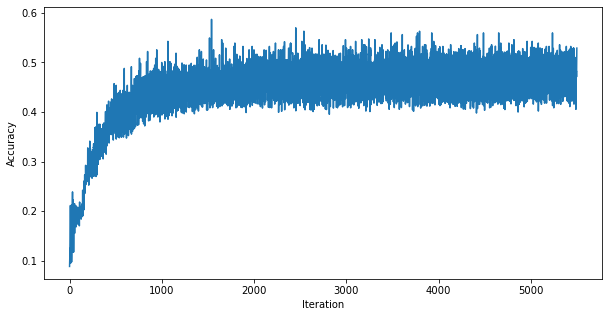

In [17]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

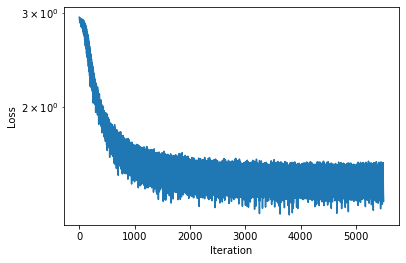

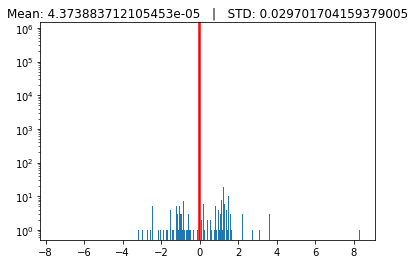

In [18]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 9.673267326732674


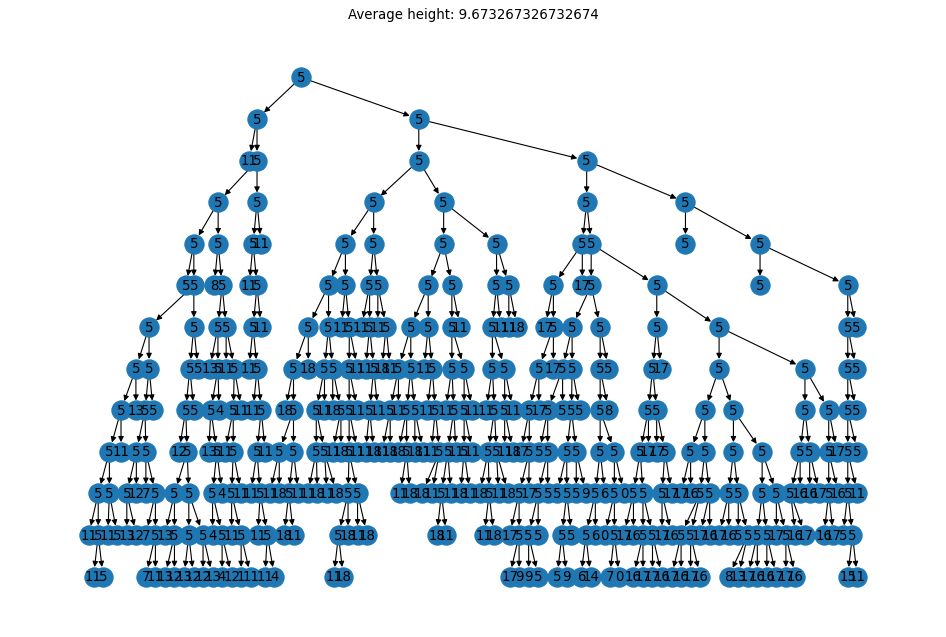

In [19]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [20]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 202


In [21]:
method = 'MLE'

In [22]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [23]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 37 ==============
============== Pattern 38 ==============
============== Pattern 39 ==============
============== Pattern 40 ==============
============== Pattern 41 ==============
============== Pattern 42 ==============
============== Pattern 43 ==============
============== Pattern 44 ==============
============== Pattern 45 ==============
============== Pattern 46 ==============
============== Pattern 47 ==============
============== Pattern 48 ==============
============== Pattern 49 ==============
============== Pattern 50 ==============
============== Pattern 51 ==============
============== Pattern 52 ==============
============== Pattern 53 ==============
============== Pattern 54 ==============
============== Pattern 55 ==============
============== Pattern 56 ==============
============== Pattern 57 ==============
============== Pattern 58 ==============
============== Pattern 59 ==============
============== Pattern 60 ==============
============== P

In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()